In [1]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
library(latex2exp)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names

# Data loading and visualization

## Loading

In [2]:
data_ACC <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

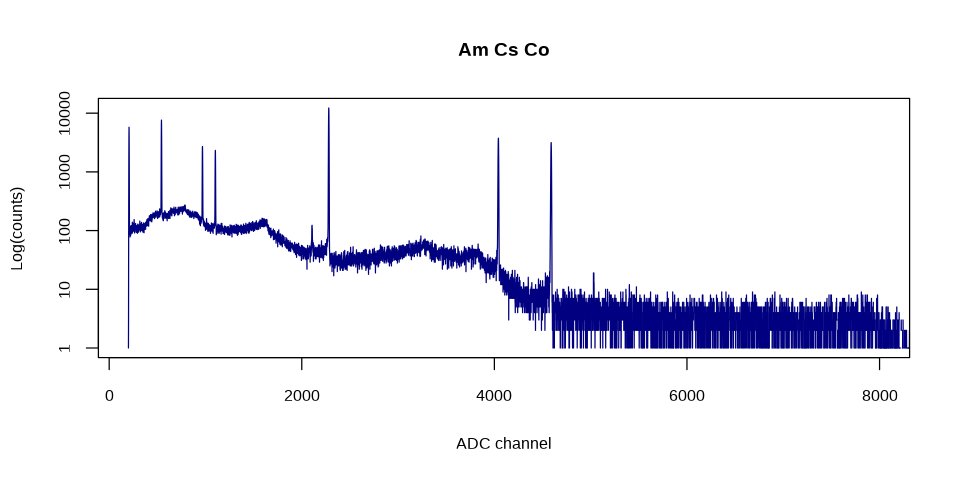

In [7]:
set_plot_dimensions(8, 4)

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,8000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [4]:
ACC_energies <-c(59.5409,661.657,1173.228,1332.51,2505.69)
df_ACC <- data.frame(ACC_energies)
row.names(df_ACC)<-c("Am","Cs","Co_1","Co_2","Co_3")
df_ACC


,ACC_energies
Am,59.5409
Cs,661.6570
Co_1,1173.2280
Co_2,1332.5100
Co_3,2505.6900


## Peak detection and characterization

In [5]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    #fetches an array of counts with the peak at the center
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-5):(peak_idx+5)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    #fetches indices of a particular peak as it exists in the elements of data_range
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-5):(peak_idx+5))
    return(idx_c)
}

probe_peaks <- function(data, n.pts, pk_size){
    
    #split counts and channels into intervals of n.pts each
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    #find the range of values for each interval established in data_range
    minmax_range <- lapply(data_range, range_size)
    
    #filter the counts to return peaks larger than a certain size.
    peaks <- data_range[minmax_range > pk_size]
    
    #applies functions to gather counts in each of the peaks, and their indices in data_range
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    #build dataframe of channel indices
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    #convert indices gathered from data_range to channel values according to ch_range
    for(i in seq_along(colnames(centered_ch))){
        centered_ch[[colnames(centered_ch)[i]]] = ch_range[[names(lx)[i]]][lx[[i]]]
    }
    
    #build dataframe of count values
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    #bind together channel values and count values, with "Xi" corresponding to "Yi", i = 1, 2, ...
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(data_ACC, 80, 2000)

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”

In [22]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}
############ New function ##############
grab_peak <- function(segment, data, peak_width){
    
    #finds the Ch corresponding to the maximum no. of counts
    peak_ch <- filter(segment, counts == max(counts))$Ch
    
    #slices the original dataframe symmetrically around the channel found with filter()
    peak_data <- data[(peak_ch - peak_width%/%2):(peak_ch + peak_width%/%2),]
    return(peak_data)
}


probe_peaks <- function(data, search_width, pk_size, peak_width = 20){

    peaks_list <- NULL
    counter <- 0
    for(i in seq(0, length(data$counts) - search_width, search_width)){
        
        #set up a data segment of (search_width) points to search over
        segment <- data[i:(i + search_width),]
        
        #Convert to log in case the count is too large
        log_counts <- sapply(segment$counts, log)
        
        segment$counts[which(!is.finite(log_counts))] <- 0
        #Check if data segment exceeds threshold
        if(log(range_size(segment$counts) ) < log(pk_size)){
            next
        }
        else{
            counter <- counter + 1
            
            #Make list of data.frame elements
            peaks_list[[counter]] <- grab_peak(segment, data, peak_width)
            #Rename each pair of data.frame columns appended to the list Xcounter and Ycounter
            colnames(peaks_list[[counter]]) <- c(paste('X', counter, sep = ''), paste('Y', counter, sep = ''))
        }
    }
    #bind all columns in the list together into a single dataframe
    centered_peaks <- bind_cols(peaks_list)
    return(centered_peaks)
}
########### New function ###########
convert_to_list <- function(pk_df){
    pk_list <- list()
    counter <- 0
    for(i in seq(1, length(pk_df),2)){
        counter <- counter + 1
        t <- NULL
        t$x <- pk_df[[i]][pk_df$Y1!=0]
        t$y <- pk_df[[i+1]][pk_df$Y1!=0]
        pk_list[[counter]] <- t    
    }
    return(pk_list)
}
########### New function ###########
plot_peaks <- function(peaks_df){
    the_plot <- ggplot(data = peaks_df)
    x_vars <- NULL; y_vars <- NULL
    for(name in colnames(peaks_df)){
        if(strsplit(name, '')[[1]][[1]]== 'X'){
            x_vars <- c(x_vars, name)
        }
        else if(strsplit(name, '')[[1]][[1]] == 'Y'){
            y_vars <- c(y_vars, name)
        }
    }
    for(i in seq_along(x_vars)){
        the_plot <- the_plot + geom_line(aes_string(x = x_vars[i],y = y_vars[i]))
    }
    the_plot <- the_plot + xlab('Ch') + ylab('counts')
    return(the_plot)
}
centered_peaks <- probe_peaks(data_ACC, 80, 1000,peak_width =50)

In [23]:
centered_peaks 

X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7
180,0,517,180,943,139,1076,94,2254,54,4016,35,4564,14
181,0,518,195,944,160,1077,120,2255,56,4017,24,4565,5
182,0,519,201,945,166,1078,97,2256,58,4018,21,4566,10
183,0,520,197,946,155,1079,90,2257,38,4019,14,4567,13
184,0,521,197,947,121,1080,108,2258,54,4020,28,4568,9
185,0,522,200,948,156,1081,112,2259,71,4021,22,4569,4
186,0,523,191,949,136,1082,113,2260,63,4022,32,4570,7
187,0,524,234,950,135,1083,124,2261,53,4023,25,4571,9
188,0,525,173,951,170,1084,122,2262,60,4024,21,4572,8
189,0,526,222,952,135,1085,128,2263,53,4025,46,4573,14


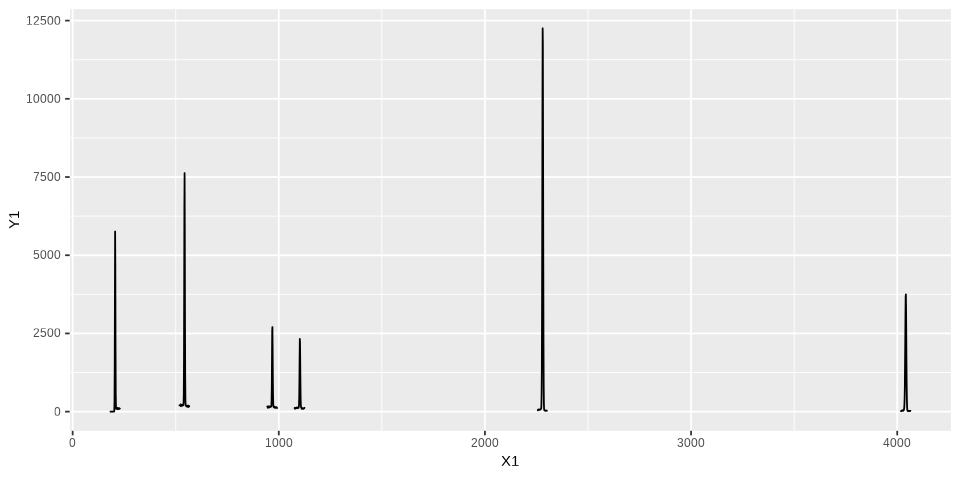

In [24]:
ggplot(data=centered_peaks)+geom_line(aes(X1,Y1))+
geom_line(aes(X2,Y2))+
geom_line(aes(X3,Y3))+
geom_line(aes(X4,Y4))+
geom_line(aes(X5,Y5))+
geom_line(aes(X6,Y6))#+
#geom_line(aes(X7,Y7))

# Peak processing 

In [27]:
t1 <- NULL
t1$x <- data_ACC$Ch[203:215]
t1$y <- data_ACC$counts[203:215]

t2 <- NULL
t2$x <- centered_peaks$X2
t2$y <- centered_peaks$Y2

t3 <- NULL
t3$x <- centered_peaks$X3
t3$y <- centered_peaks$Y3

t4 <- NULL
t4$x <- centered_peaks$X4
t4$y <- centered_peaks$Y4

t5 <- NULL
t5$x <- centered_peaks$X5
t5$y <- centered_peaks$Y5

t6 <- NULL
t6$x <- centered_peaks$X6
t6$y <- centered_peaks$Y6


peaks <-list(t1,t2,t3,t4,t5)

In [9]:
t1 <- NULL
t1$x <- data_ACC$Ch[203:215]
t1$y <- data_ACC$counts[203:215]

t2 <- NULL
t2$x <- data_ACC$Ch[530:550]
t2$y <- data_ACC$counts[530:550]

t3 <- NULL
t3$x <- data_ACC$Ch[960:980]
t3$y <- data_ACC$counts[960:980]

t4 <- NULL
t4$x <- data_ACC$Ch[1090:1115]
t4$y <- data_ACC$counts[1090:1115]

t5 <- NULL
t5$x <- data_ACC$Ch[2260:2300]
t5$y <- data_ACC$counts[2260:2300]




peaks <-list(t1,t2,t3,t4,t5)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

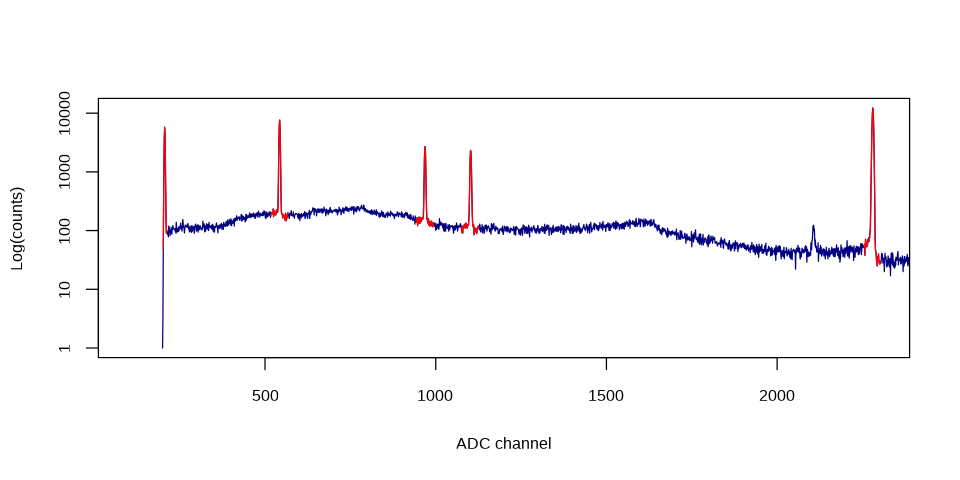

In [28]:
#Just to control we are picking the right ones
set_plot_dimensions(8,4)
plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    #xlim=c(150,3500),ylim=c(1.e-1,1.e5),
    xlim=c(100,2300),
    main = "",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:length(peaks)){lines(peaks[[i]]$x,peaks[[i]]$y,col="red")}
#lines(peaks[[1]]$x,peaks[[1]]$y,col="black")


In [29]:
peak_properties <- function (peaks){
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()
w_mean <-c()
w_std <-c()

for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dnorm(",A.max,",",50,")
    B ~ dnorm(",B.max,",",10,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))
#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain)$statistics)

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
w_mean <- c(w_mean,w)
w_std  <- c(w_std,summary(chain)$statistics[3,2])
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}
    
results <- NULL
results$chains  <- chains
results$x0_mean <- x0_mean
results$x0_std  <- x0_std
results$w_mean  <- w_mean
results$w_std   <- w_std
    return(results)
    }

[1] "peak 1"
          Mean          SD     Naive SE Time-series SE
A  5758.002286 0.137216363 0.0025052166   0.0026606501
B    89.978377 0.316393029 0.0057765200   0.0057753829
w     1.262844 0.006213732 0.0001134467   0.0001100821
x0  206.183663 0.009927679 0.0001812538   0.0001812387


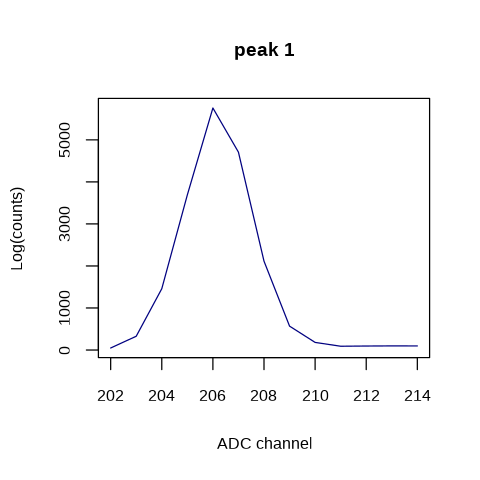

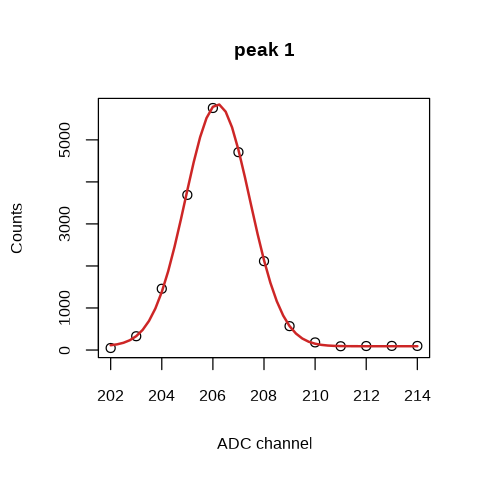

[1] "peak 2"
          Mean          SD     Naive SE Time-series SE
A  7625.999081 0.139122892 0.0025400249   0.0025407193
B   173.401362 0.310100231 0.0056616297   0.0055623299
w     1.532215 0.006185003 0.0001129222   0.0001164816
x0  542.815481 0.009775258 0.0001784710   0.0002090094


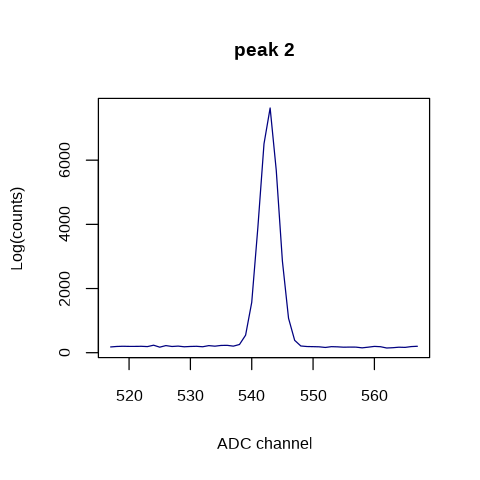

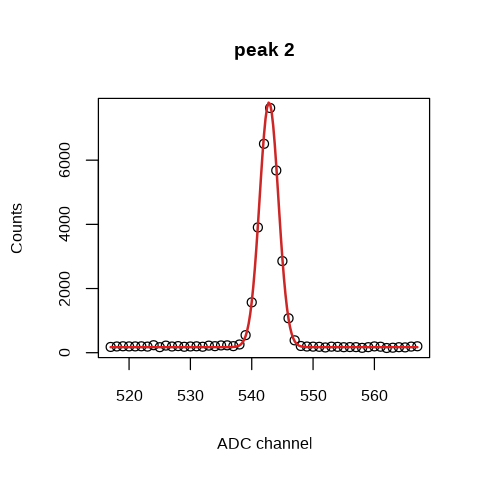

[1] "peak 3"
          Mean         SD     Naive SE Time-series SE
A  2702.996499 0.14272229 0.0026057405   0.0025500408
B   121.720575 0.31287022 0.0057122025   0.0052737283
w     1.676247 0.01171549 0.0002138947   0.0002138587
x0  968.728658 0.01804007 0.0003293651   0.0003293372


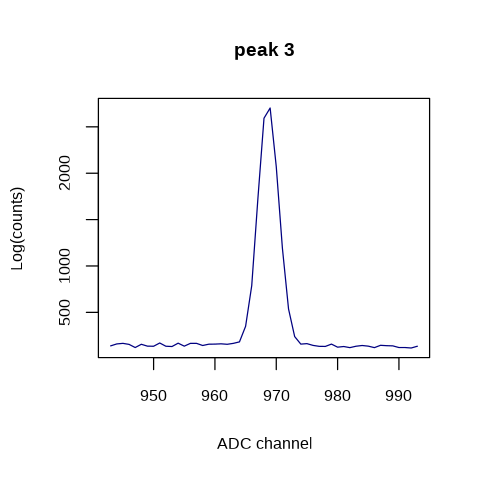

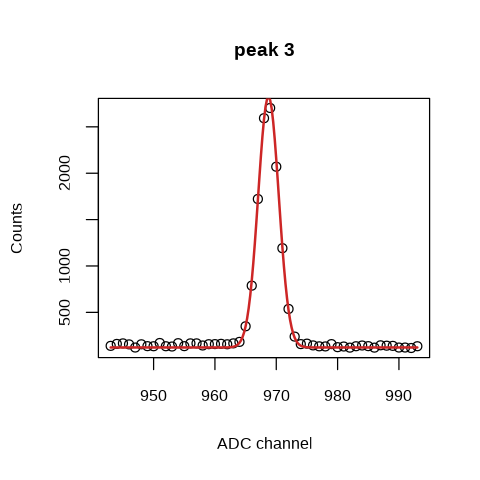

[1] "peak 4"
          Mean         SD     Naive SE Time-series SE
A  2324.995986 0.14238276 0.0025995416   0.0025993635
B    90.939108 0.30105685 0.0054965210   0.0054089605
w     1.785223 0.01320403 0.0002410716   0.0002410180
x0 1102.445514 0.01996221 0.0003644585   0.0003592975


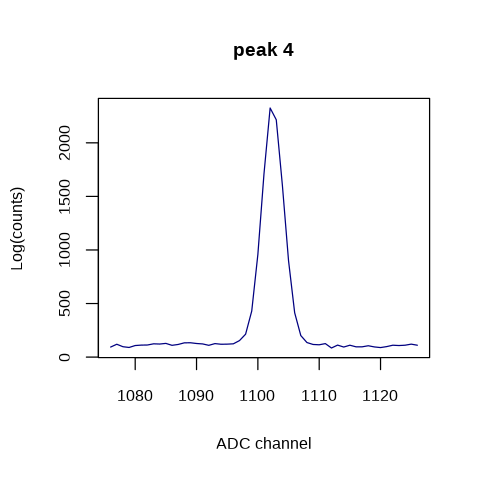

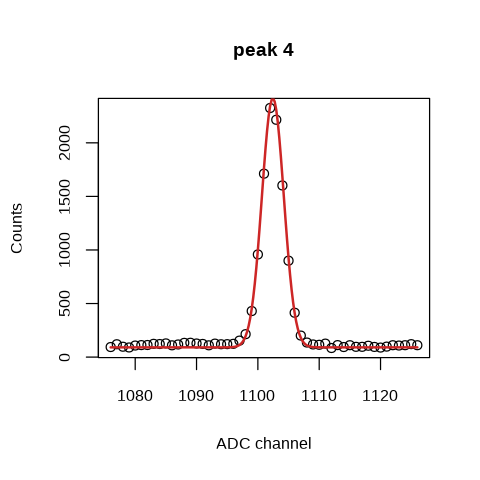

[1] "peak 5"
           Mean          SD     Naive SE Time-series SE
A  12254.001515 0.143189860 2.614277e-03   2.701424e-03
B     38.994506 0.301122414 5.497718e-03   5.262724e-03
w      2.052096 0.005019017 9.163429e-05   9.162206e-05
x0  2280.295021 0.008357578 1.525878e-04   1.525206e-04


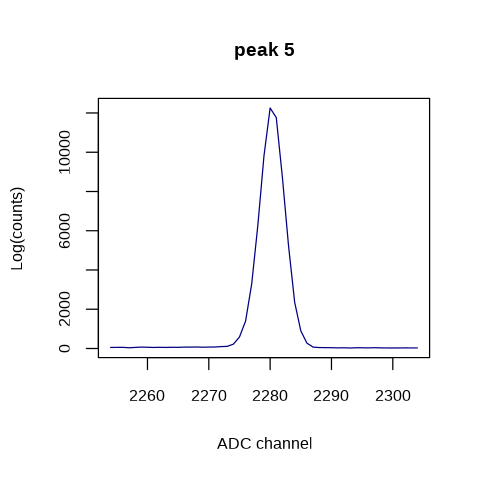

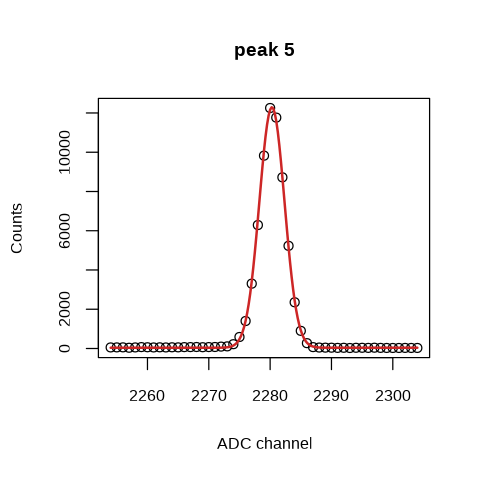

In [30]:
ACC_properties <- peak_properties(peaks)

#### Americum

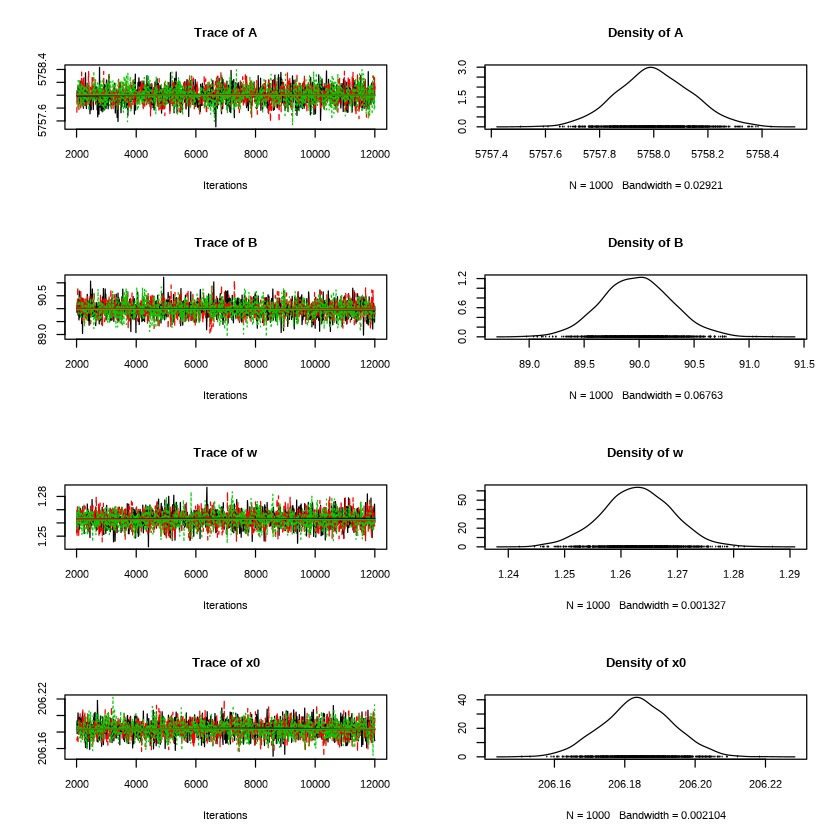

In [31]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[1]])

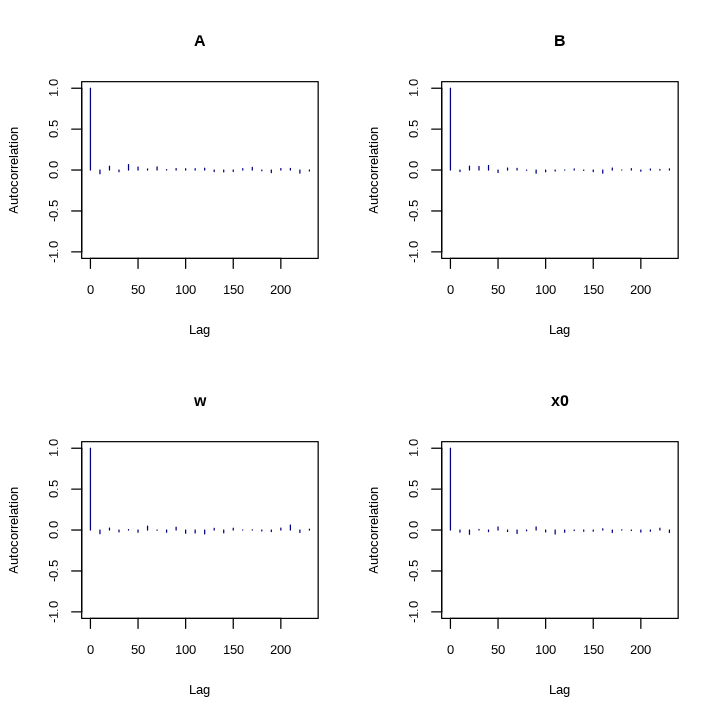

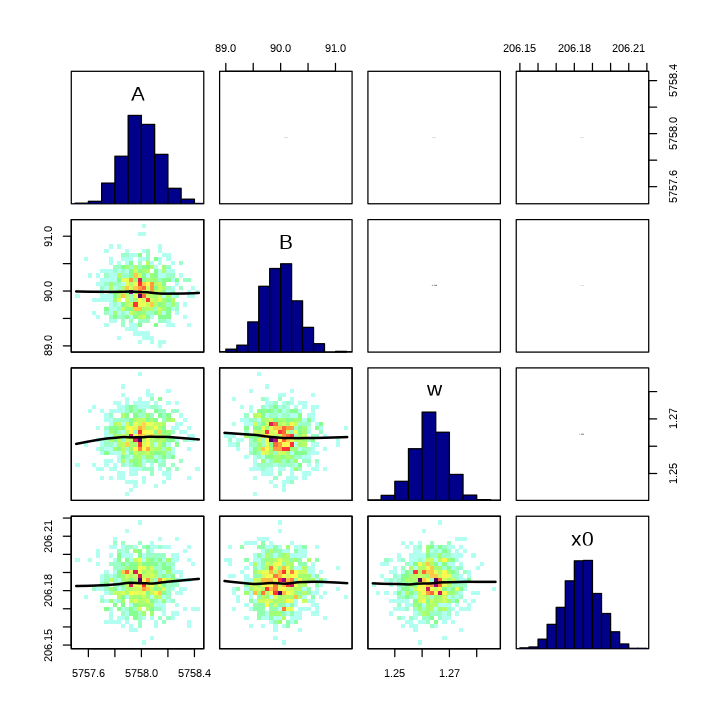

In [32]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[1]][1], col='navy')

correlationPlot((ACC_properties$chains[[1]][1]))

#### Cs

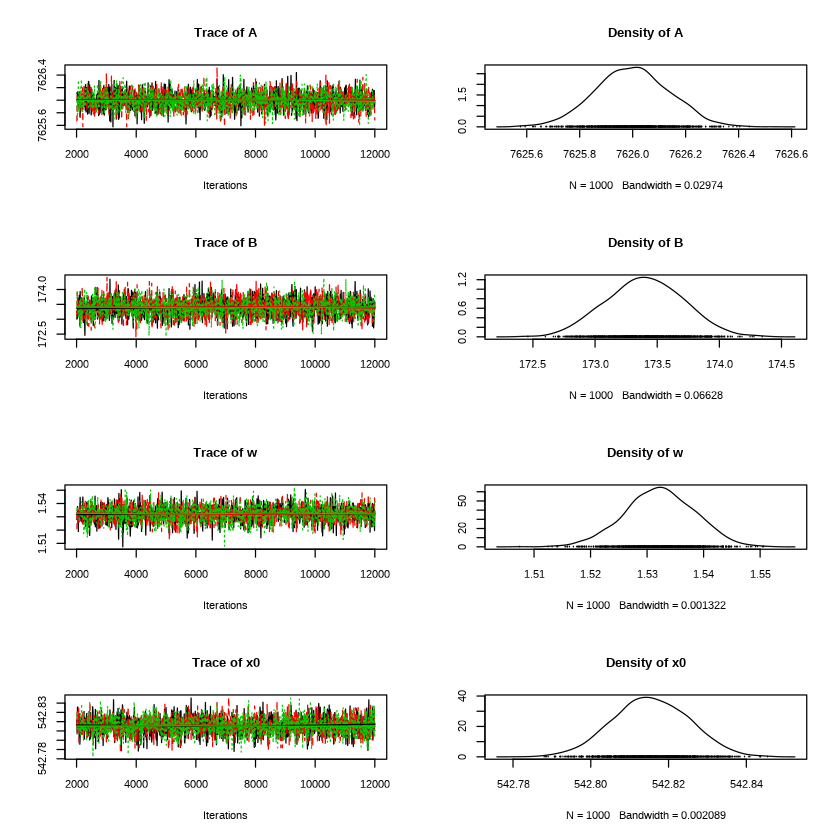

In [33]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[2]])

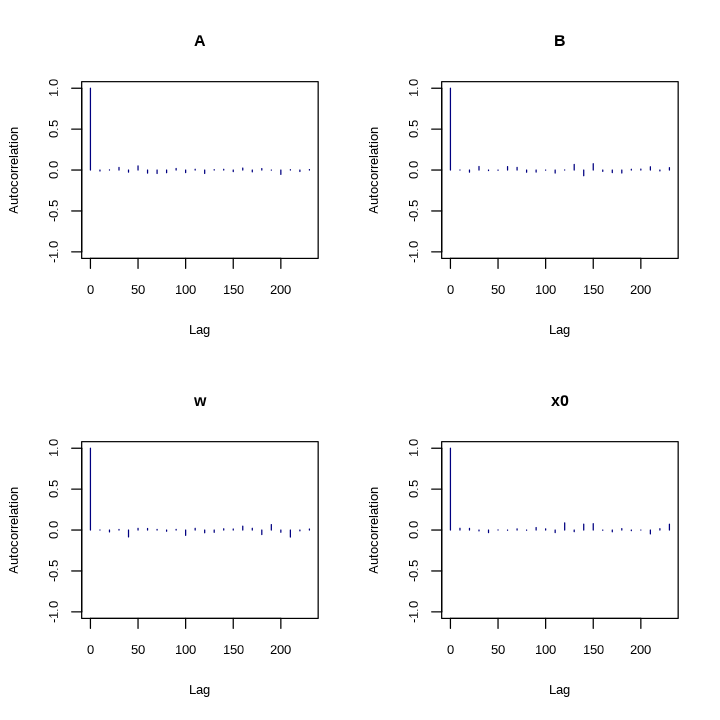

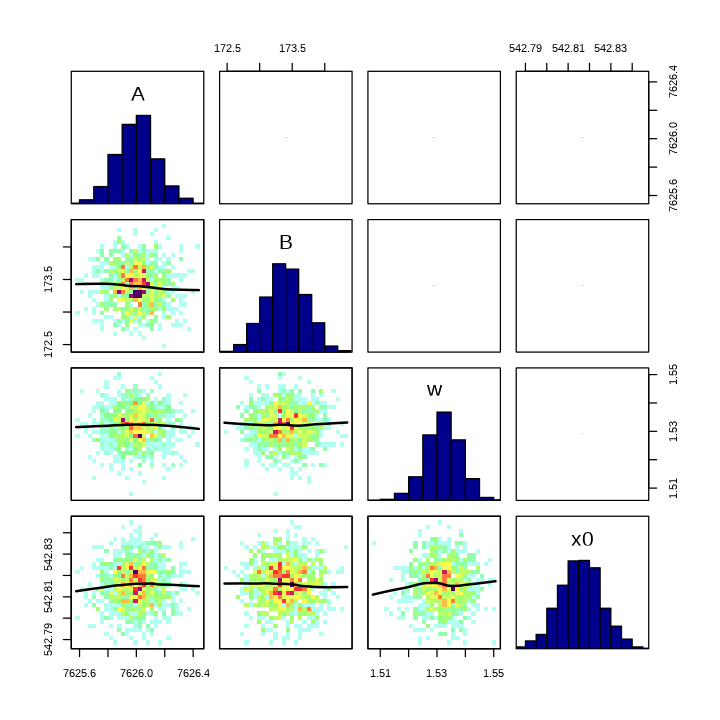

In [34]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[2]][1], col='navy')

correlationPlot((ACC_properties$chains[[2]][1]))

### Co 1

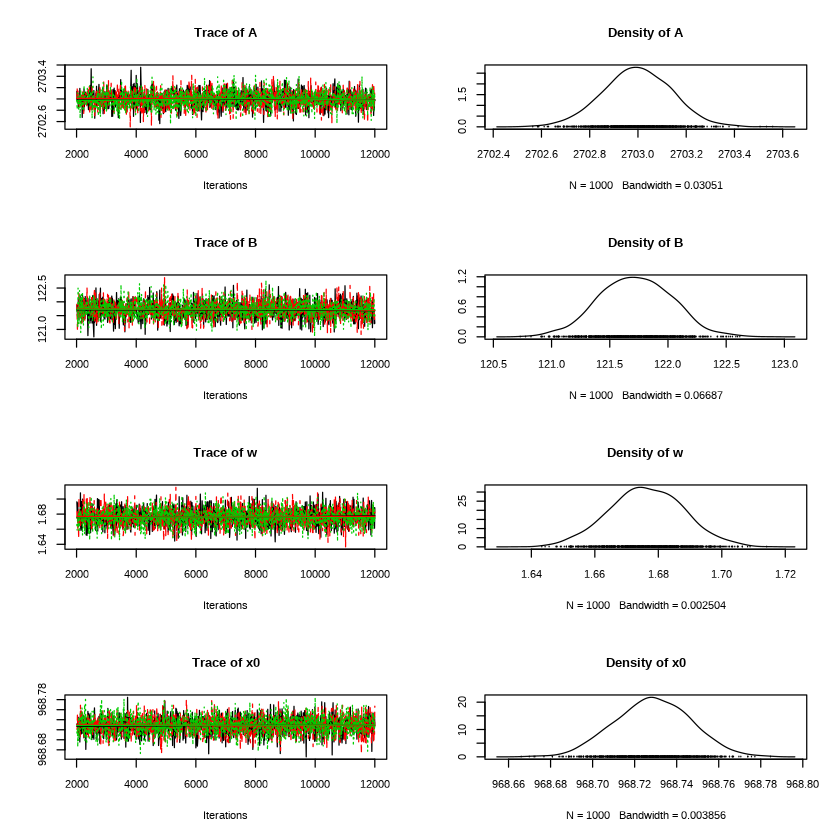

In [35]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[3]])

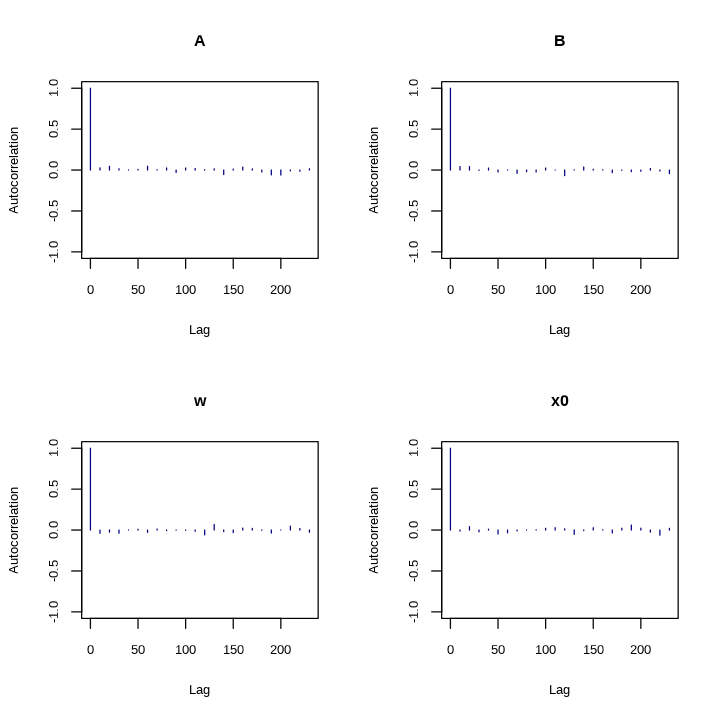

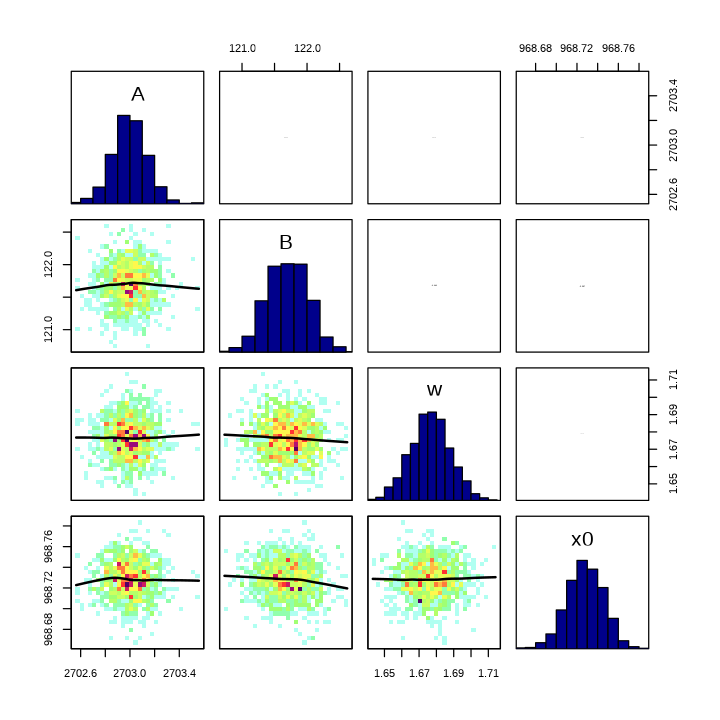

In [36]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[3]][1], col='navy')

correlationPlot((ACC_properties$chains[[3]][1]))

#### Co 2


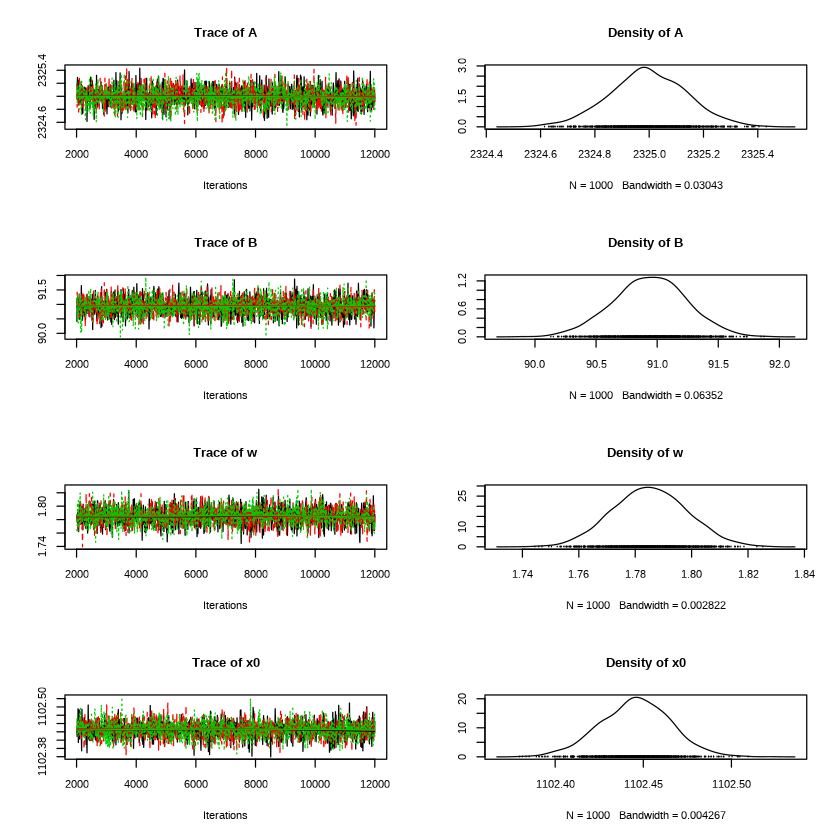

In [37]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[4]])

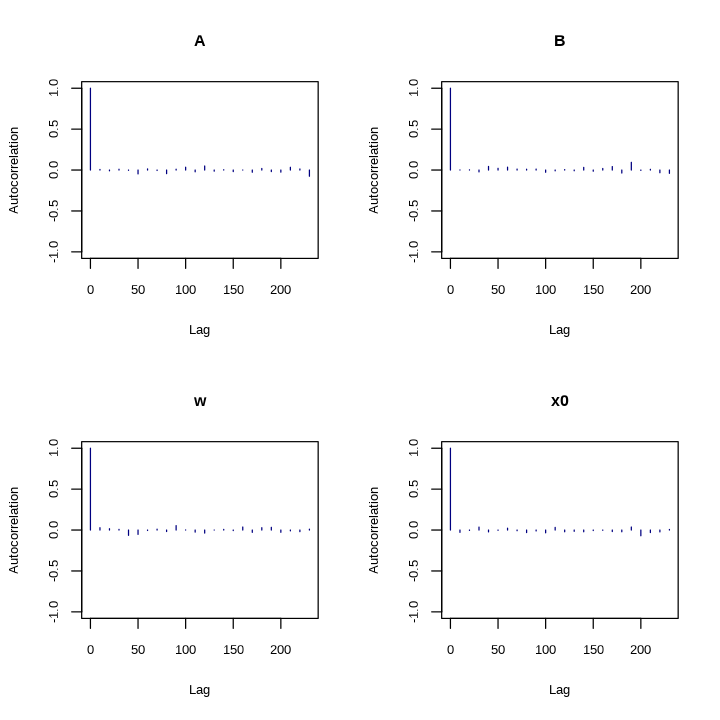

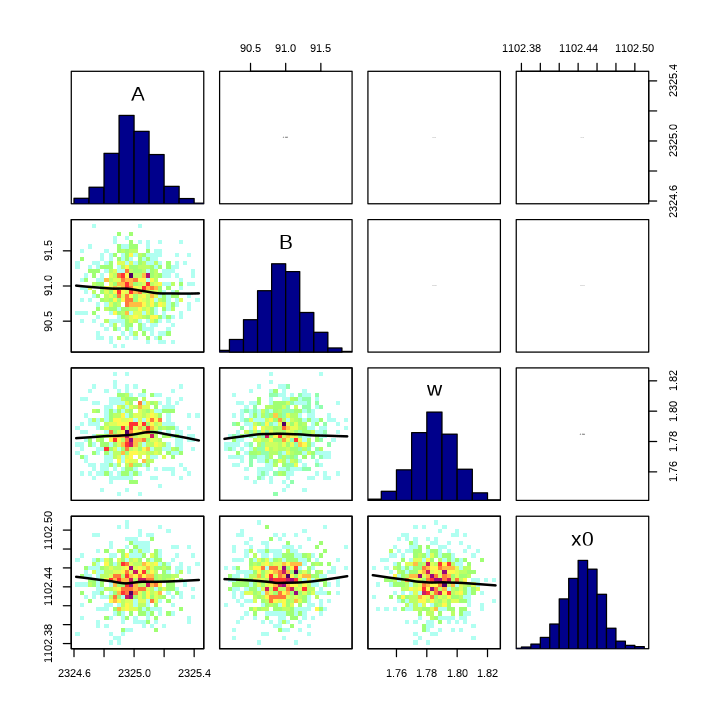

In [38]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[4]][1], col='navy')

correlationPlot((ACC_properties$chains[[4]][1]))

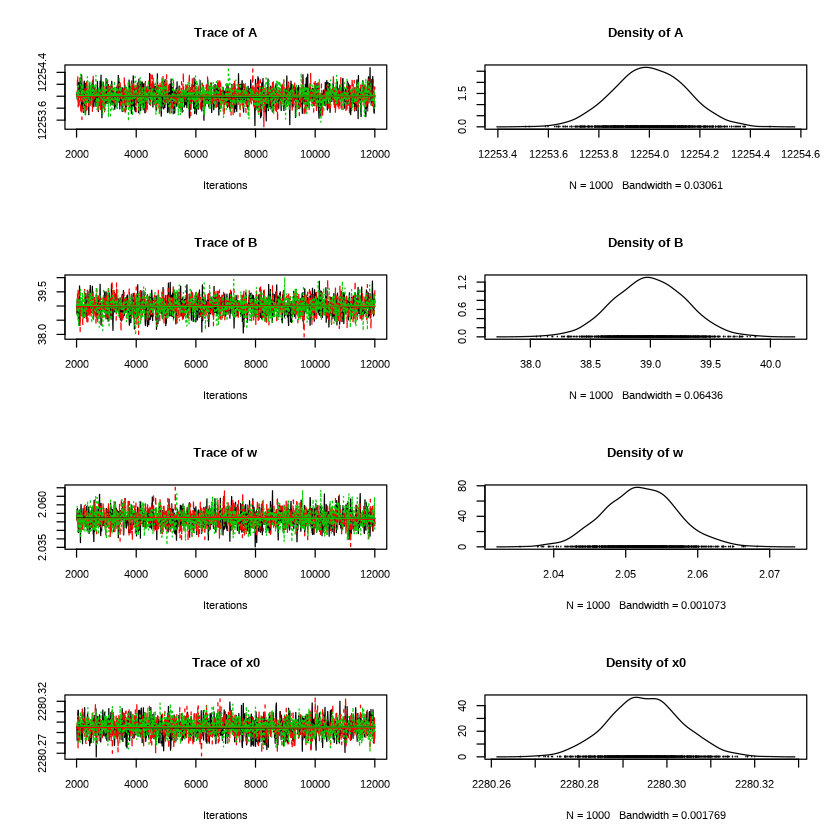

In [39]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[5]])

## Energy calibration

In [40]:
df_ACC$x0_mean <- ACC_properties$x0_mean
df_ACC$x0_std  <- ACC_properties$x0_std
df_ACC$w_mean  <- ACC_properties$w_mean
df_ACC$w_std   <- ACC_properties$w_std


In [41]:
df_ACC

,ACC_energies,x0_mean,x0_std,w_mean,w_std
Am,59.5409,206.1837,0.009927679,1.262844,0.006213732
Cs,661.6570,542.8155,0.009775258,1.532215,0.006185003
Co_1,1173.2280,968.7287,0.018040071,1.676247,0.011715494
Co_2,1332.5100,1102.4455,0.019962215,1.785223,0.013204035
Co_3,2505.6900,2280.2950,0.008357578,2.052096,0.005019017


In [42]:
linear_fit <- lm( df_ACC$ACC_energies[1:5] ~ df_ACC$x0_mean[1:5] )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_ACC$Ch*slope

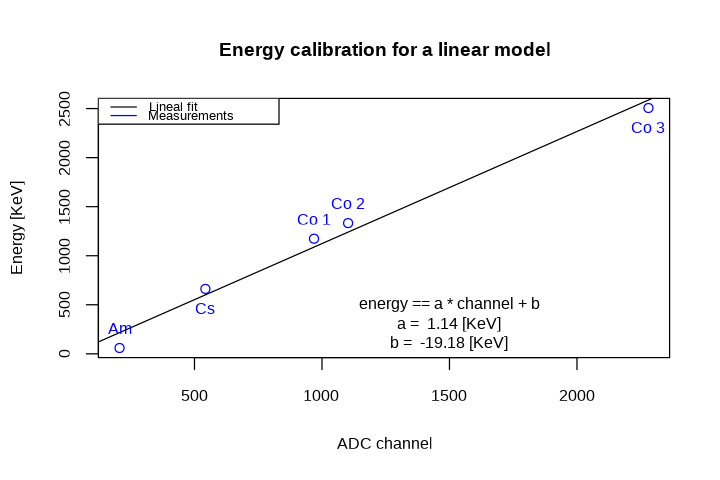

In [43]:
set_plot_dimensions(6, 4)
plot(df_ACC$x0_mean,df_ACC$ACC_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_ACC$Ch,calibrated_energy)

legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("black","blue"), lty=1, cex=0.8)

text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(1500, 500, "energy == a * channel + b")
text(1500, 300, paste("a = ", sprintf("%.2f",slope),"[KeV]"))
text(1500, 100, paste("b = ", sprintf("%.2f",intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

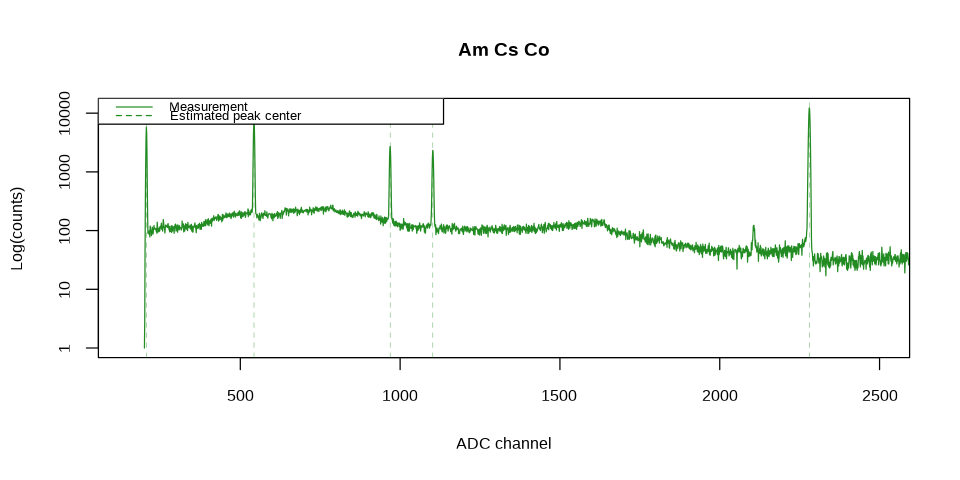

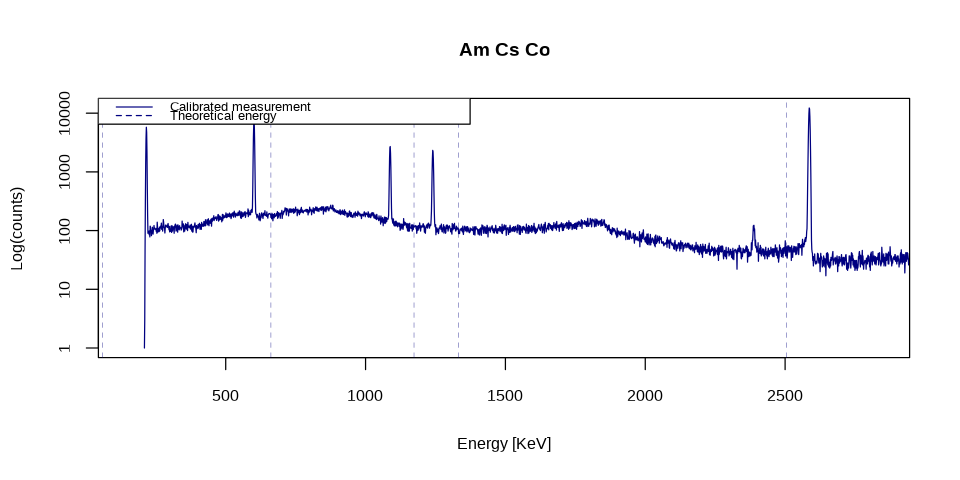

In [44]:
set_plot_dimensions(8, 4)

xmin <- 150;xmax<-2500
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:5){ abline(v=ACC_properties$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}
legend("topleft", legend=c("Measurement","Estimated peak center"),
       col=c("forestgreen"), lty=1:2, cex=0.8)


plot(calibrated_energy,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:5){
abline(v=df_ACC$ACC_energies[i],col="navy",lty=2,lwd=0.3)}
legend("topleft", legend=c("Calibrated measurement","Theoretical energy"),
       col=c("navy"), lty=1:2, cex=0.8)

## Resolution study

In [45]:
df_ACC$FWHM_mean <- 2*sqrt(2*log(2))*ACC_properties$w_mean
df_ACC$FWHM_std  <- 2*sqrt(2*log(2))*ACC_properties$w_std

In [46]:
df_ACC

,ACC_energies,x0_mean,x0_std,w_mean,w_std,FWHM_mean,FWHM_std
Am,59.5409,206.1837,0.009927679,1.262844,0.006213732,2.973770,0.01463222
Cs,661.6570,542.8155,0.009775258,1.532215,0.006185003,3.608092,0.01456457
Co_1,1173.2280,968.7287,0.018040071,1.676247,0.011715494,3.947261,0.02758788
Co_2,1332.5100,1102.4455,0.019962215,1.785223,0.013204035,4.203878,0.03109313
Co_3,2505.6900,2280.2950,0.008357578,2.052096,0.005019017,4.832317,0.01181888


In [47]:
df_Resolution_ACC <- NULL
df_Resolution_ACC$x <- df_ACC$ACC_energies
df_Resolution_ACC$y <- df_ACC$FWHM_mean

In [48]:
cat("model{

    #The likelihood:
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],sigma);
 
    } 


    # Priors for  

    w ~ dunif(1.e-3,1);
    we ~ dnorm(3,0.25);
    sigma ~ dnorm(0,1);
    #F ~dnorm(0.113,0.05)

      
}", file="Models/ACC_resolution.bug")
model <- "Models/ACC_resolution.bug"

In [49]:
init <- NULL
init$w   <- 3.e-3
init$we  <- 3;   init$sigma  <- 0.1;#   init$F  <- 0.113
init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")

In [50]:
chain_number <- 10
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [51]:
jm <- jags.model(model,
                 df_Resolution_ACC,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

update(jm, burnin)

,Mean,SD,Naive SE,Time-series SE
sigma,1.4602465,0.645062167,6.450622e-03,5.839878e-03
w,0.0115959,0.005776858,5.776858e-05,5.779459e-05
we,2.6782706,1.046048377,1.046048e-02,1.152078e-02


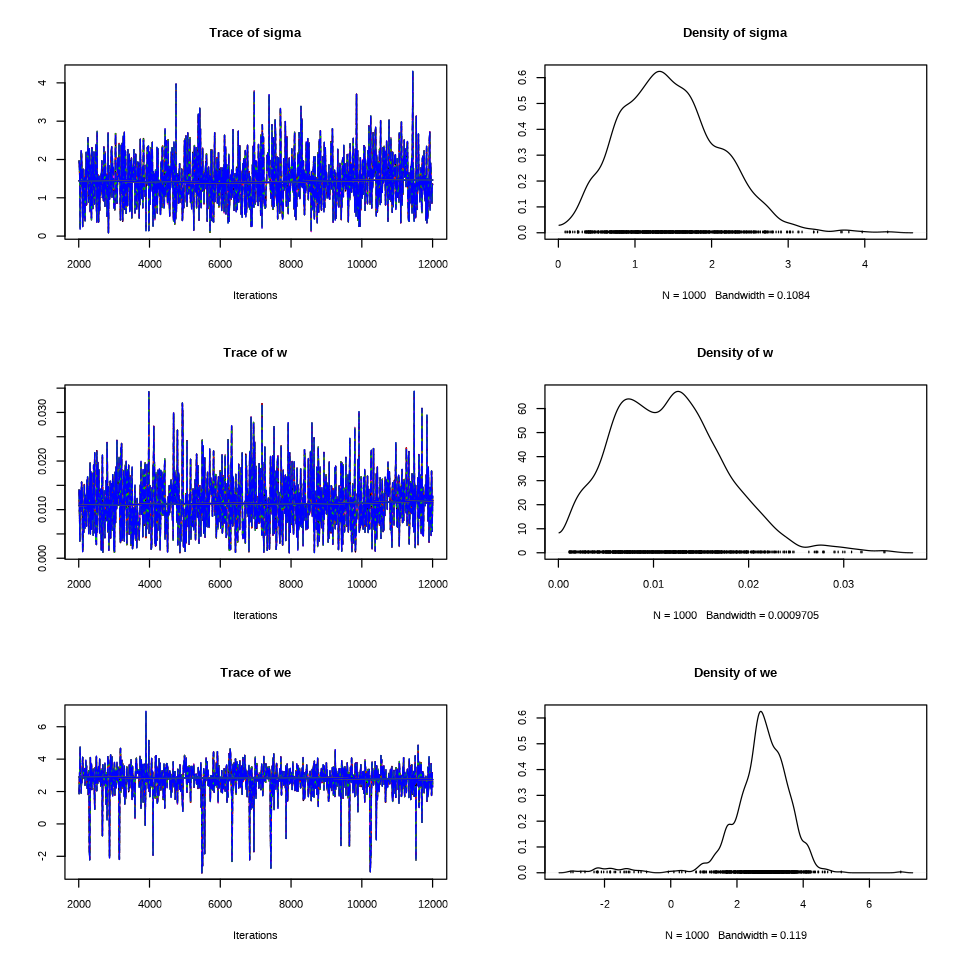

In [52]:
chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)
summary(chain)$statistics
set_plot_dimensions(8,8)
plot(chain)

In [53]:
w  <- summary(chain)$statistics[2,1]; sw<-  summary(chain)$statistics[2,2]
we  <- summary(chain)$statistics[3,1]; swe <- summary(chain)$statistics[3,2]
w
we

[1] 0.0115959

[1] 2.678271

In [54]:
df_ACC

,ACC_energies,x0_mean,x0_std,w_mean,w_std,FWHM_mean,FWHM_std
Am,59.5409,206.1837,0.009927679,1.262844,0.006213732,2.973770,0.01463222
Cs,661.6570,542.8155,0.009775258,1.532215,0.006185003,3.608092,0.01456457
Co_1,1173.2280,968.7287,0.018040071,1.676247,0.011715494,3.947261,0.02758788
Co_2,1332.5100,1102.4455,0.019962215,1.785223,0.013204035,4.203878,0.03109313
Co_3,2505.6900,2280.2950,0.008357578,2.052096,0.005019017,4.832317,0.01181888


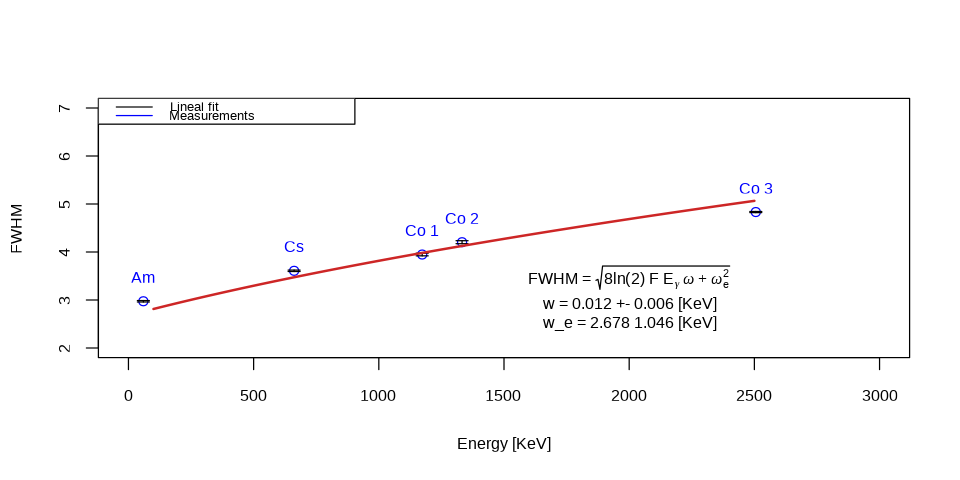

In [55]:
fano <-0.115
    
x <- seq(100,2500,1)
f <- sqrt(4*2*log(2) * fano * x * w + we**2)
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 4)
plot(df_ACC$ACC_energies,df_ACC$FWHM_mean,col="blue",
    xlim=c(0,3000), ylim=c(2,7), 
    xlab="Energy [KeV]",ylab="FWHM",
    main="")

arrows(df_ACC$ACC_energies, df_ACC$FWHM_mean-df_ACC$FWHM_std,
       df_ACC$ACC_energies, df_ACC$FWHM_mean+df_ACC$FWHM_std,
       length=0.05, angle=90, code=3)
lines(x,f, lwd=2, col='firebrick3')


legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("black","blue"), lty=1, cex=0.8)

text(df_ACC$ACC_energies,df_ACC$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2000, 3.5,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2000, 2.9, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2000, 2.5, paste("w_e =", sprintf("%.3f",we),sprintf("%.3f",swe),"[KeV]"))

# Thallium

In [38]:
data_T <- read.table("data/IC48A_Th.txt", col.names = c('Ch', 'counts')) 

As we don't know which are the peaks to use we cheated, there is a paper from Baudis et.al https://arxiv.org/pdf/1508.05731.pdf with the spectrum from Th in a Germanium detector and there the peaks are identified so we picked two of them which were clearly the same as in our spectrum and used them to "calibrate the energy". We used this information to identify the peaks in our spectrum.

The 511 energy peak is between the channels 3150,3250 centered at 3215

The 2614 energy peak is between the channels 16200,16600 centered at 16450

As the lines we plotted clearly fit existing peaks, we trust that we are picking the correct ones. 

In [39]:
T_energies <-c(238.632,300.089,510.74,583.187,727.330,763.45,785.37,860.53,893.408,1078.63,1512.70,1592.511,1620.738,2103.511,2614.511)
df_T <- data.frame(T_energies)
row.names(df_T)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8", "Th 9", "Th 10", "Th 11",
                "Th 12", "Th 13", "Th 14", "Th 15")
df_T

,T_energies
Th 1,238.632
Th 2,300.089
Th 3,510.740
Th 4,583.187
Th 5,727.330
Th 6,763.450
Th 7,785.370
Th 8,860.530
Th 9,893.408
Th 10,1078.630


In [40]:
ch1<-3215;en1<-511
ch2<-16450;en2<-2614
b<-(ch1-ch2)/(en1-en2)
a<-ch1-en1*b
ch_th <- a+ df_T$T_energies *b

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

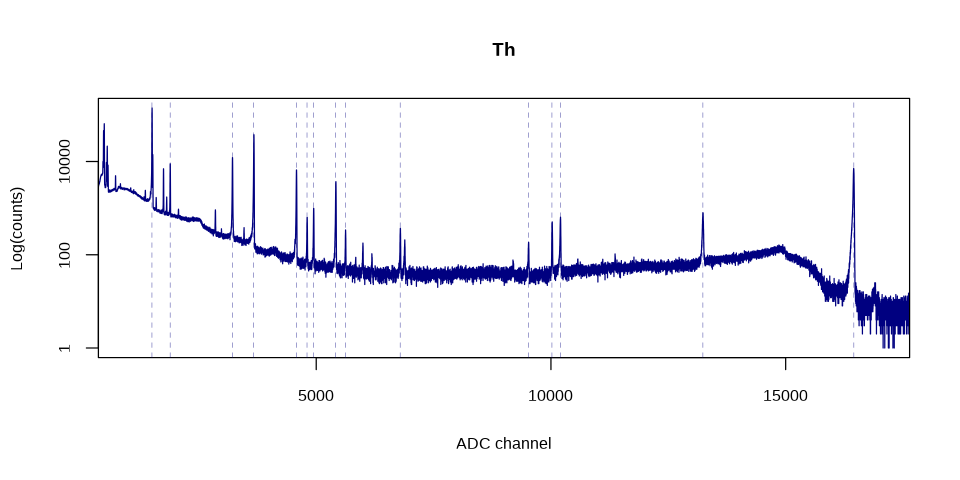

In [41]:
set_plot_dimensions(8, 4)

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){ abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}


In [42]:
th_1 <- NULL
th_1$x <- data_T$Ch[1450:1550]
th_1$y <- data_T$counts[1450:1550]

th_2 <- NULL
th_2$x <- data_T$Ch[1850:1950]
th_2$y <- data_T$counts[1850:1950]

th_3 <- NULL
th_3$x <- data_T$Ch[3100:3300]
th_3$y <- data_T$counts[3100:3300]

th_4 <- NULL
th_4$x <- data_T$Ch[3600:3750]
th_4$y <- data_T$counts[3600:3750]

th_5 <- NULL
th_5$x <- data_T$Ch[4500:4650]
th_5$y <- data_T$counts[4500:4650]

th_6 <- NULL
th_6$x <- data_T$Ch[4750:4850]
th_6$y <- data_T$counts[4750:4850]

th_7 <- NULL
th_7$x <- data_T$Ch[4900:5000]
th_7$y <- data_T$counts[4900:5000]

th_8 <- NULL
th_8$x <- data_T$Ch[5350:5475]
th_8$y <- data_T$counts[5350:5475]

th_9 <- NULL
th_9$x <- data_T$Ch[5600:5650]
th_9$y <- data_T$counts[5600:5650]

th_10 <- NULL
th_10$x <- data_T$Ch[6750:6850]
th_10$y <- data_T$counts[6750:6850]

th_11 <- NULL
th_11$x <- data_T$Ch[9500:9550]
th_11$y <- data_T$counts[9500:9550]

th_12 <- NULL
th_12$x <- data_T$Ch[10000:10060]
th_12$y <- data_T$counts[10000:10060]

th_13 <- NULL
th_13$x <- data_T$Ch[10150:10250]
th_13$y <- data_T$counts[10150:10250]

th_14 <- NULL
th_14$x <- data_T$Ch[13150:13300]
th_14$y <- data_T$counts[13150:13300]

th_15 <- NULL
th_15$x <- data_T$Ch[16200:16600]
th_15$y <- data_T$counts[16200:16600]


th_peaks <-list(th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

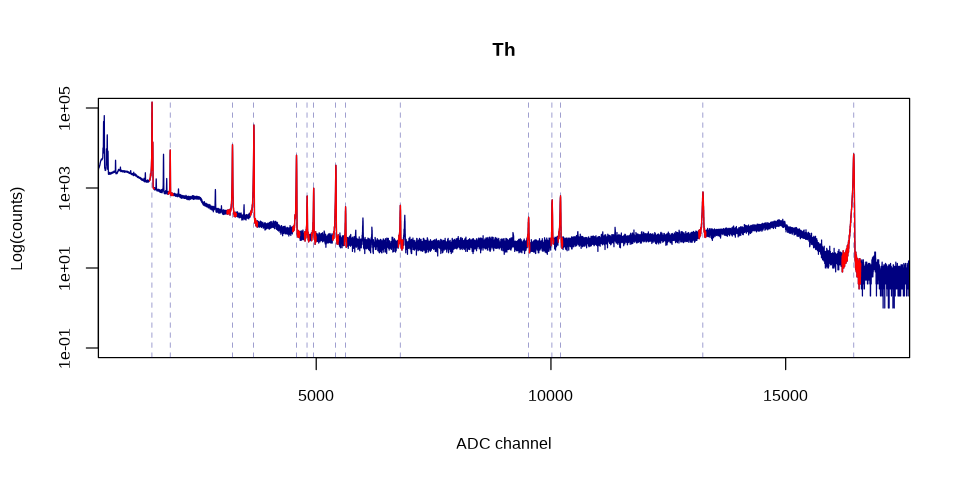

In [43]:
#Just to control we are picking the right ones
plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),ylim=c(1.e-1,1.e5),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}
for (i in 1:length(th_peaks)){lines(th_peaks[[i]]$x,th_peaks[[i]]$y,col="red")}

[1] "peak 1"
           Mean          SD     Naive SE Time-series SE
A  1.403170e+05 0.143474276 2.619470e-03   2.627969e-03
B  1.523744e+03 0.313760425 5.728455e-03   5.728521e-03
w  2.704313e+00 0.001938908 3.539945e-05   3.470804e-05
x0 1.503164e+03 0.003010777 5.496901e-05   5.493689e-05


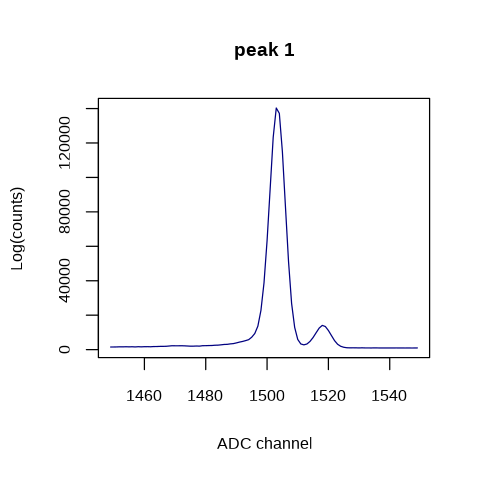

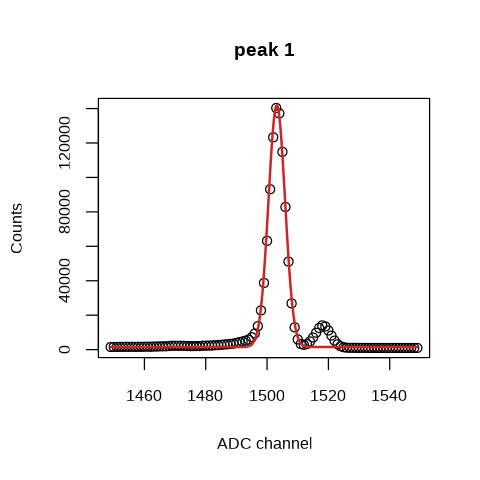

[1] "peak 2"
          Mean          SD     Naive SE Time-series SE
A  8897.991563 0.137440569 0.0025093100   0.0027038412
B   695.544027 0.303542403 0.0055419007   0.0053254259
w     2.755689 0.009396985 0.0001715647   0.0001850766
x0 1890.172198 0.013881068 0.0002534325   0.0002534266


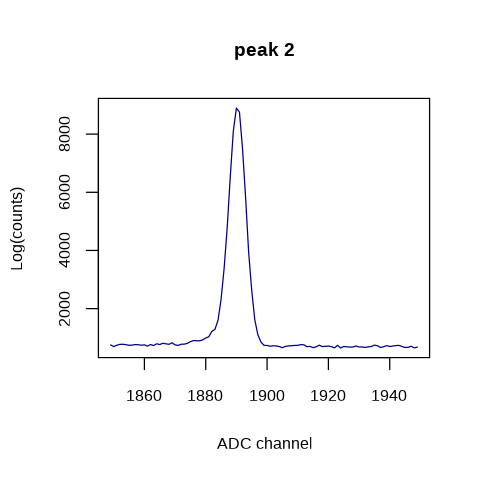

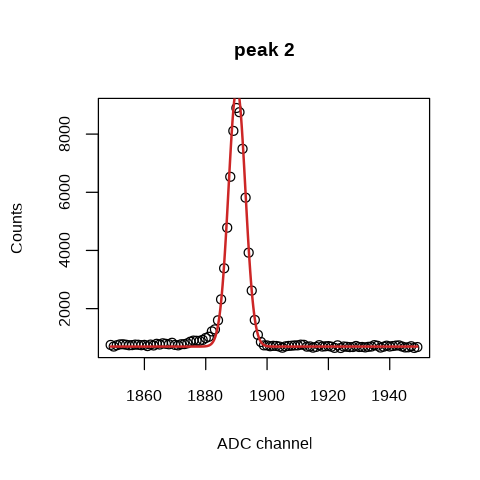

[1] "peak 3"
           Mean          SD     Naive SE Time-series SE
A  12094.982828 0.141114337 0.0025763835   0.0025509820
B    215.033076 0.301935007 0.0055125538   0.0054182804
w      4.097722 0.008928485 0.0001630111   0.0001663172
x0  3216.230486 0.013444651 0.0002454646   0.0002556432


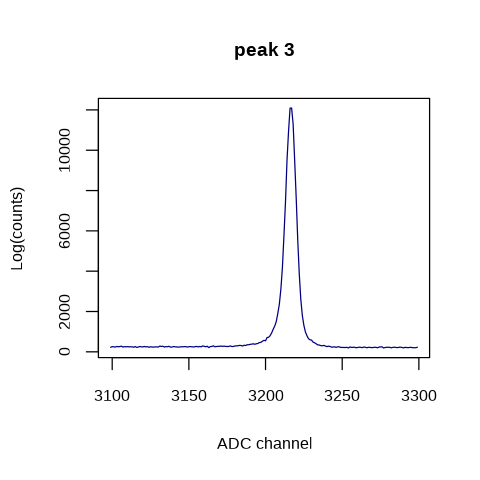

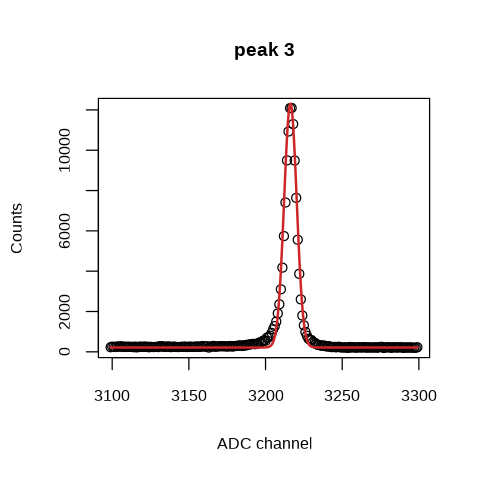

[1] "peak 4"
           Mean          SD     Naive SE Time-series SE
A  37494.992597 0.141965874 2.591930e-03   2.592786e-03
B    206.034951 0.305982776 5.586456e-03   5.587932e-03
w      3.928637 0.004509703 8.233554e-05   8.377619e-05
x0  3672.190516 0.006952109 1.269276e-04   1.205426e-04


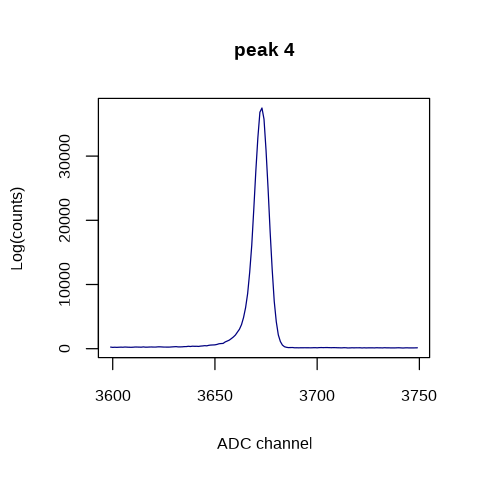

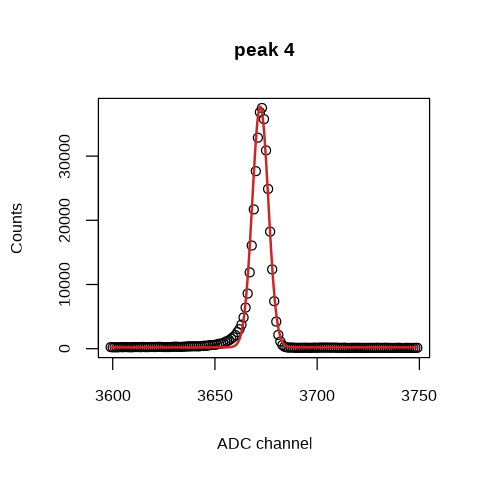

[1] "peak 5"
          Mean         SD     Naive SE Time-series SE
A  6586.985465 0.14070225 0.0025688599   0.0024488851
B    84.724329 0.29425078 0.0053722596   0.0051929329
w     4.352159 0.01155184 0.0002109068   0.0002109235
x0 4579.220876 0.01813206 0.0003310447   0.0003309950


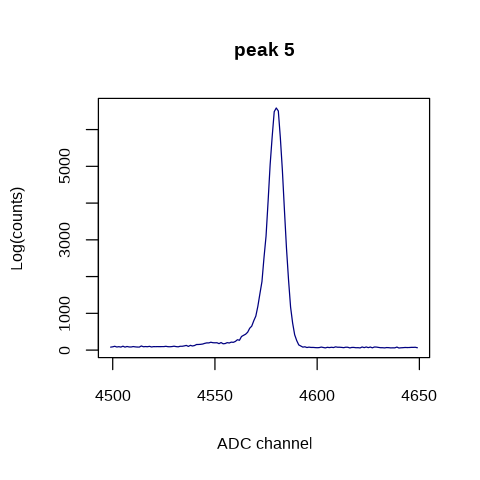

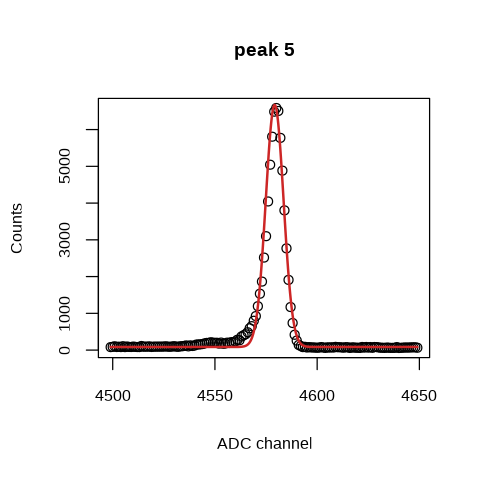

[1] "peak 6"
         Mean         SD     Naive SE Time-series SE
A   629.98434 0.13989803 0.0025541769   0.0025121986
B    49.58773 0.28790629 0.0052564257   0.0056012701
w     4.45015 0.04813741 0.0008788649   0.0008945005
x0 4806.36464 0.06834912 0.0012478786   0.0012482919


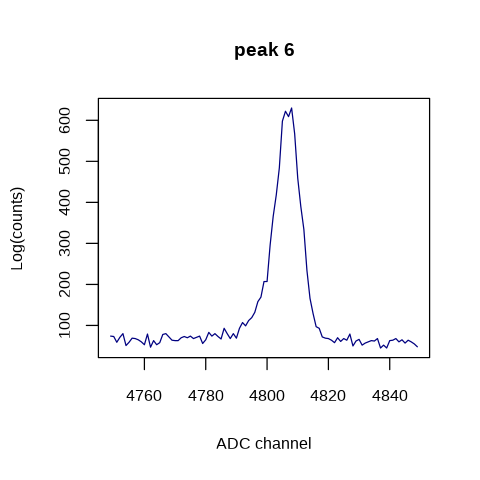

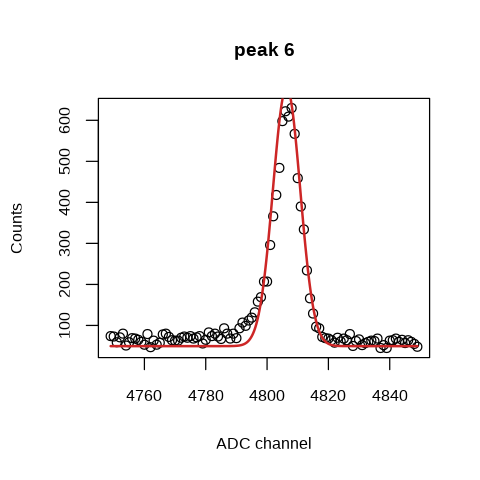

[1] "peak 7"
          Mean         SD     Naive SE Time-series SE
A   989.991804 0.13945741 0.0025461324   0.0026063900
B    50.362735 0.28674615 0.0052352444   0.0052350101
w     4.449739 0.03606761 0.0006585014   0.0006484175
x0 4945.599756 0.05061982 0.0009241872   0.0009244337


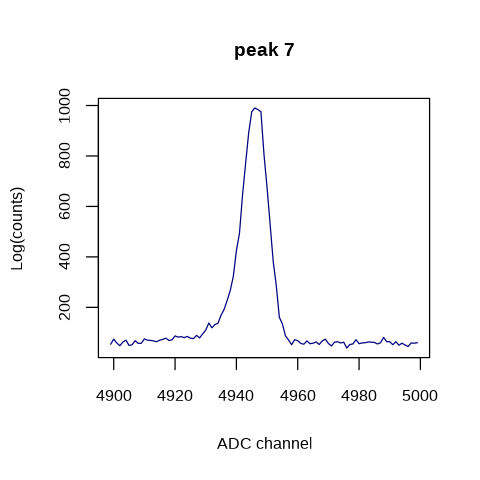

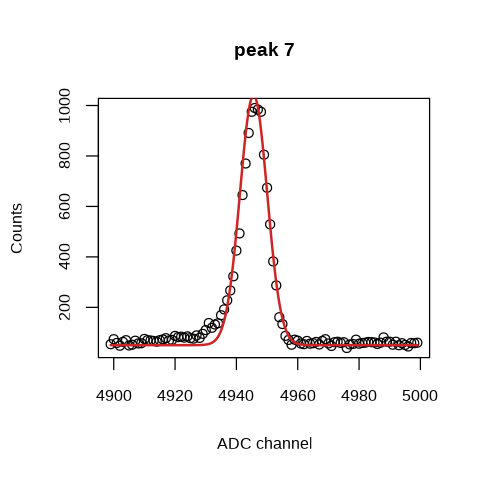

[1] "peak 8"
          Mean         SD     Naive SE Time-series SE
A  3693.984706 0.14099883 0.0025742747   0.0025995593
B    52.859381 0.27632270 0.0050449391   0.0050464505
w     4.771975 0.01692611 0.0003090271   0.0003154203
x0 5417.788680 0.02641368 0.0004822457   0.0004997713


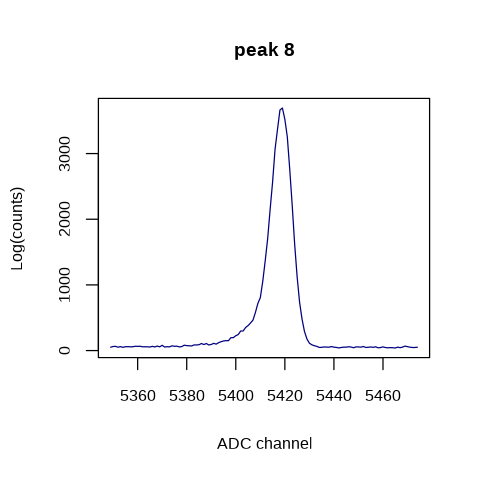

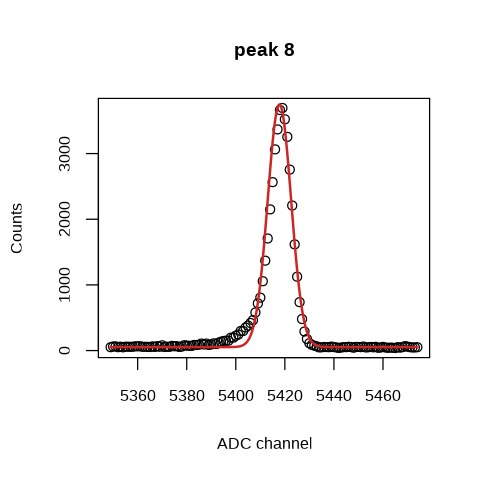

[1] "peak 9"
          Mean        SD    Naive SE Time-series SE
A   339.974187 0.1453510 0.002653734    0.002654483
B    37.867491 0.3065645 0.005597076    0.005613141
w     4.446919 0.0727574 0.001328362    0.001285242
x0 5625.065751 0.1030028 0.001880564    0.001742447


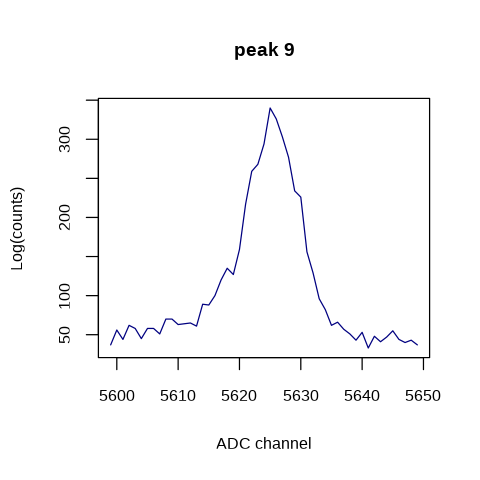

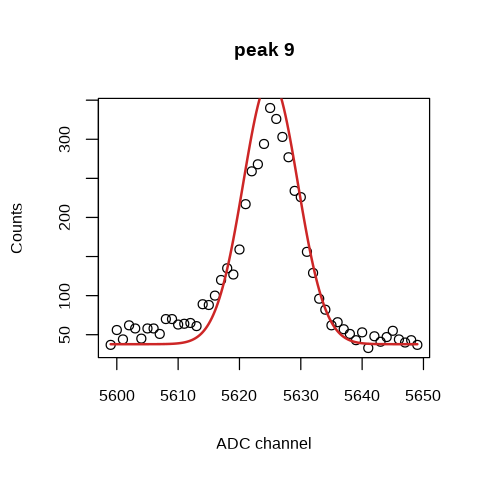

[1] "peak 10"
          Mean         SD    Naive SE Time-series SE
A   368.975737 0.14189056 0.002590555    0.002545398
B    34.954342 0.28185600 0.005145963    0.005038461
w     4.910911 0.06907490 0.001261129    0.001260420
x0 6791.421360 0.09873544 0.001802654    0.001798629


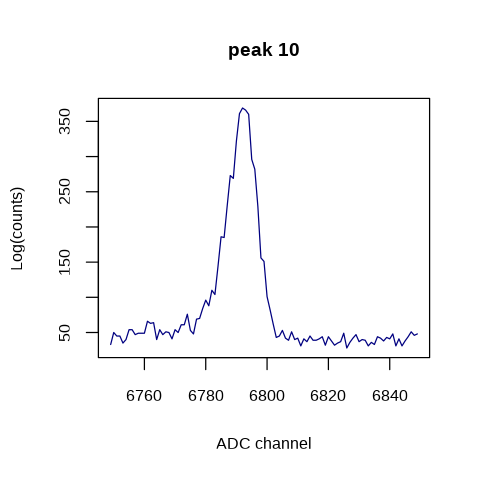

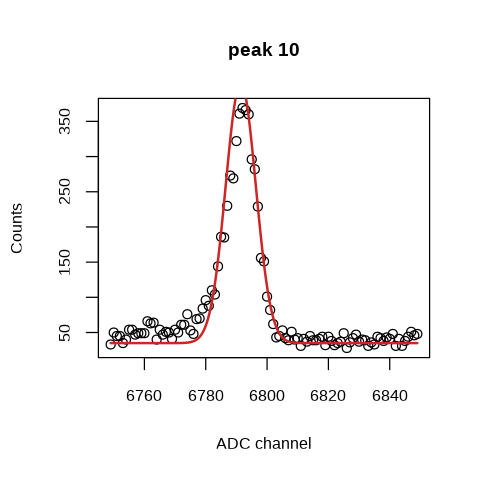

[1] "peak 11"
          Mean        SD    Naive SE Time-series SE
A   185.963878 0.1393503 0.002544177    0.002552419
B    34.517797 0.3066766 0.005599122    0.005729500
w     5.465889 0.1288768 0.002352958    0.002362065
x0 9523.178194 0.1741924 0.003180304    0.003107068


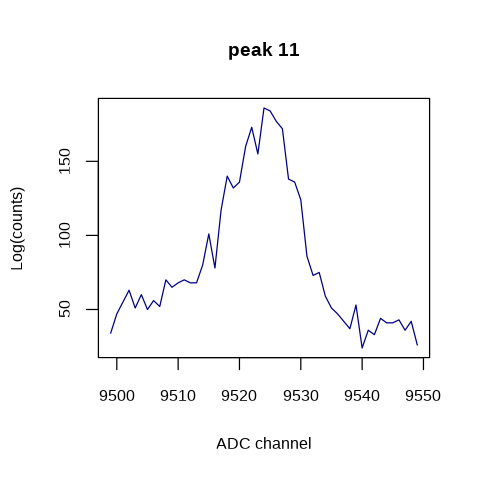

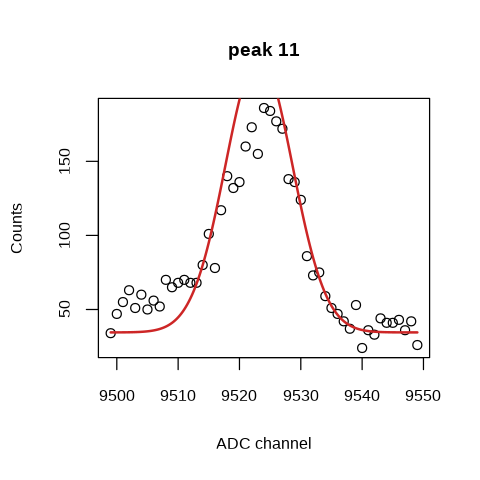

[1] "peak 12"
           Mean         SD     Naive SE Time-series SE
A    505.980740 0.13937900 0.0025447008   0.0025453406
B     40.469853 0.31503992 0.0057518158   0.0057535676
w      5.131247 0.05348334 0.0009764678   0.0009653405
x0 10025.994182 0.08111185 0.0014808931   0.0015442488


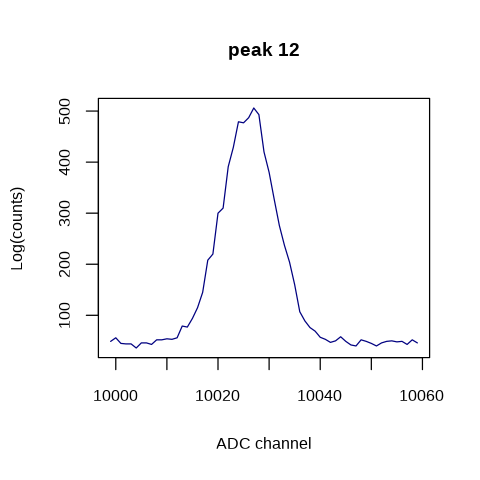

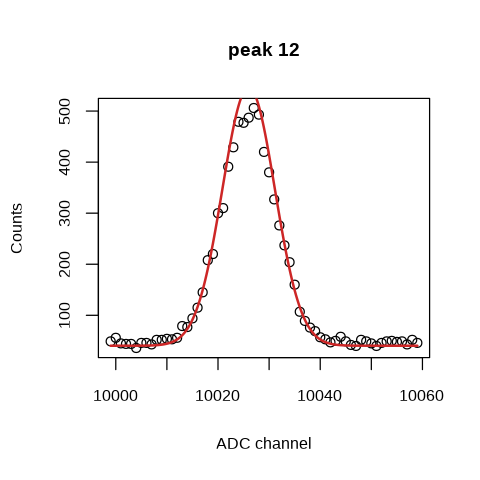

[1] "peak 13"
           Mean         SD    Naive SE Time-series SE
A    638.972608 0.14040803 0.002563488    0.002564211
B     45.595985 0.29486631 0.005383498    0.005286983
w      6.059664 0.05507225 0.001005477    0.001005754
x0 10201.758219 0.08139332 0.001486032    0.001485934


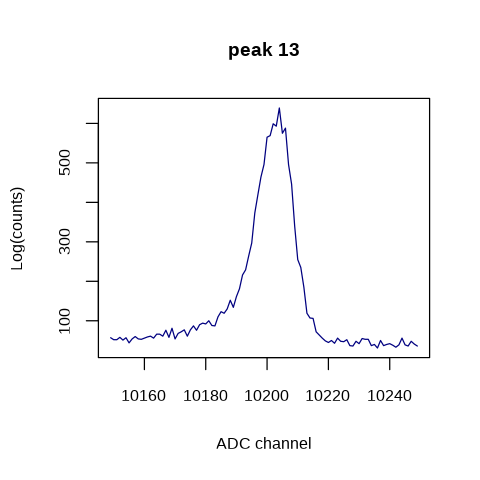

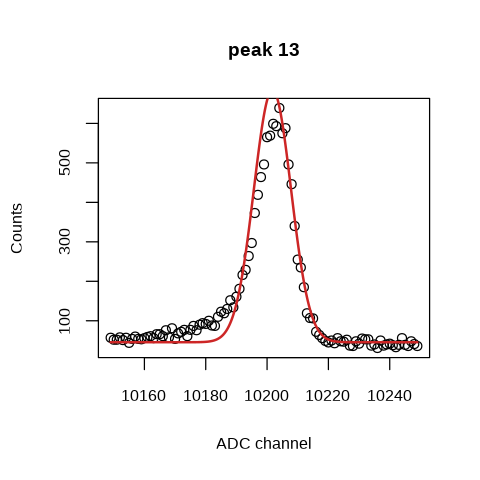

[1] "peak 14"
          Mean         SD    Naive SE Time-series SE
A    796.93995 0.14246927 0.002601121    0.002457899
B     60.77720 0.28517657 0.005206588    0.004894112
w      9.86051 0.06219045 0.001135437    0.001159072
x0 13236.79441 0.09561892 0.001745755    0.001770093


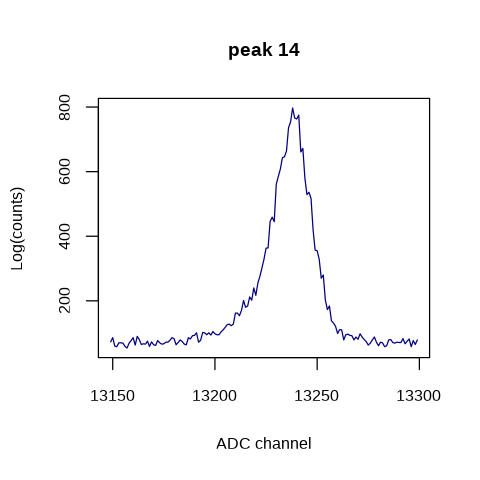

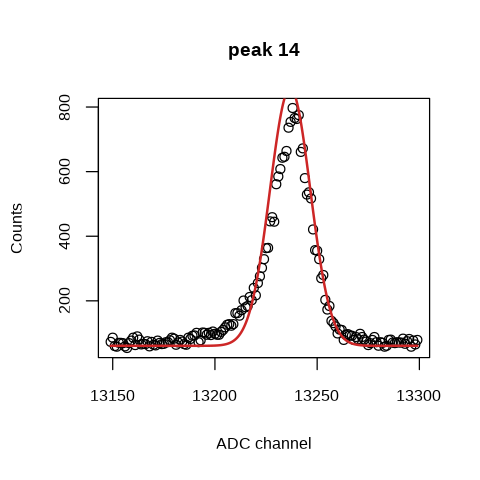

[1] "peak 15"
           Mean         SD     Naive SE Time-series SE
A   7084.945999 0.14188415 0.0025904383   0.0024839682
B     29.523329 0.19759997 0.0036076654   0.0036443294
w      9.350669 0.01730122 0.0003158755   0.0003278656
x0 16446.595849 0.02668311 0.0004871646   0.0004683286


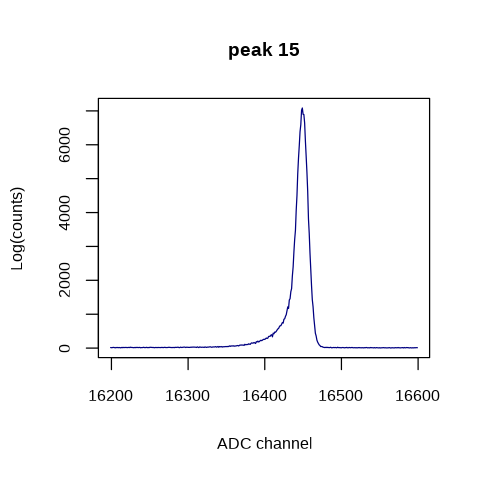

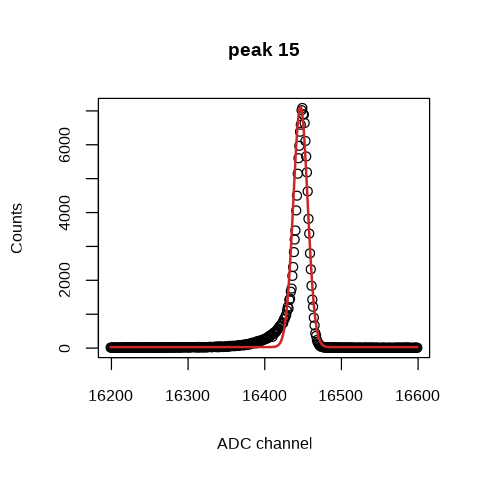

In [44]:
T_properties <- peak_properties(th_peaks)

### Energy calibration

In [45]:
df_T$x0_mean <- T_properties$x0_mean
df_T$x0_std  <- T_properties$x0_std
df_T$w_mean  <- T_properties$w_mean
df_T$w_std   <- T_properties$w_std


In [46]:
df_T

,T_energies,x0_mean,x0_std,w_mean,w_std
Th 1,238.632,1503.164,0.003010777,2.704313,0.001938908
Th 2,300.089,1890.172,0.013881068,2.755689,0.009396985
Th 3,510.740,3216.230,0.013444651,4.097722,0.008928485
Th 4,583.187,3672.191,0.006952109,3.928637,0.004509703
Th 5,727.330,4579.221,0.018132064,4.352159,0.011551840
Th 6,763.450,4806.365,0.068349125,4.450150,0.048137411
Th 7,785.370,4945.600,0.050619819,4.449739,0.036067610
Th 8,860.530,5417.789,0.026413684,4.771975,0.016926113
Th 9,893.408,5625.066,0.103002756,4.446919,0.072757402
Th 10,1078.630,6791.421,0.098735444,4.910911,0.069074900


In [47]:
linear_fit <- lm( df_T$T_energies ~ df_T$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_T$Ch*slope

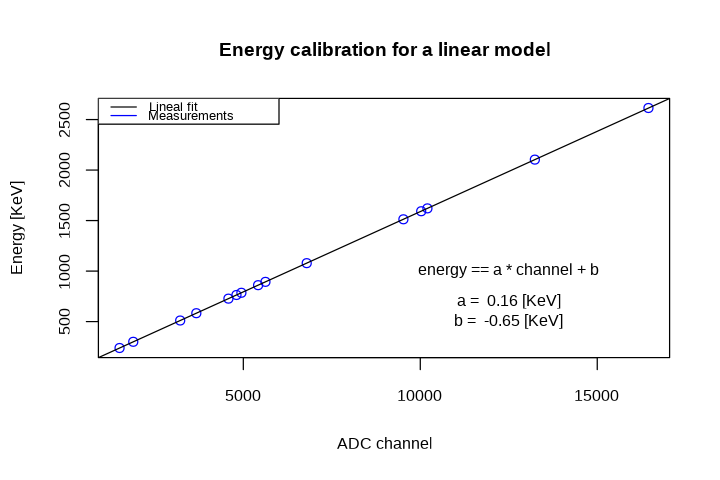

In [48]:
set_plot_dimensions(6, 4)
plot(df_T$x0_mean,df_T$T_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_T$Ch,calibrated_energy)

legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("black","blue"), lty=1, cex=0.8)

#text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(12500, 1000, "energy == a * channel + b")
text(12500, 700, paste("a = ", sprintf("%.2f",slope),"[KeV]"))
text(12500, 500, paste("b = ", sprintf("%.2f",intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

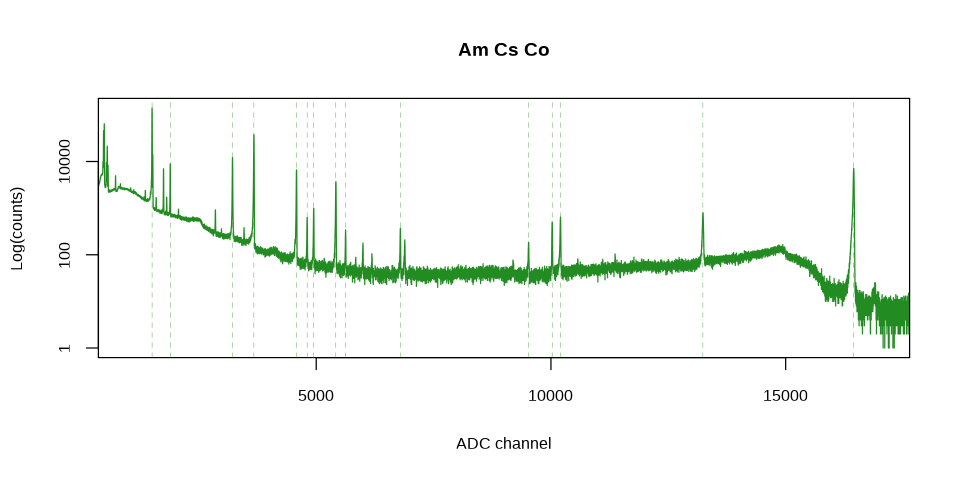

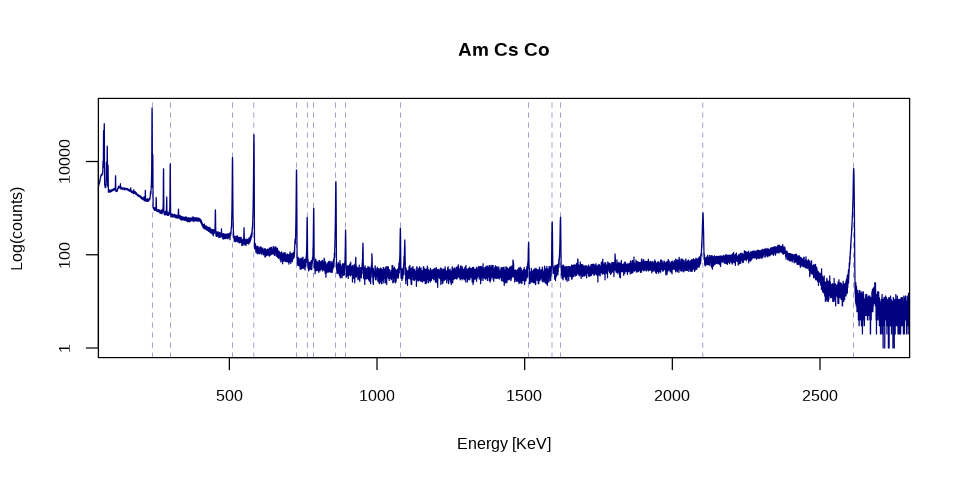

In [49]:
set_plot_dimensions(8, 4)

xmin<-1000;xmax<-17000
emin<-intercept + xmin*slope; emax<- intercept + xmax*slope

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){
    abline(v=df_T$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}



plot(calibrated_energy,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:15){
    abline(v=df_T$T_energies[i],col="navy",lty=2,lwd=0.3)}

## Resolution study

In [50]:
df_T

,T_energies,x0_mean,x0_std,w_mean,w_std
Th 1,238.632,1503.164,0.003010777,2.704313,0.001938908
Th 2,300.089,1890.172,0.013881068,2.755689,0.009396985
Th 3,510.740,3216.230,0.013444651,4.097722,0.008928485
Th 4,583.187,3672.191,0.006952109,3.928637,0.004509703
Th 5,727.330,4579.221,0.018132064,4.352159,0.011551840
Th 6,763.450,4806.365,0.068349125,4.450150,0.048137411
Th 7,785.370,4945.600,0.050619819,4.449739,0.036067610
Th 8,860.530,5417.789,0.026413684,4.771975,0.016926113
Th 9,893.408,5625.066,0.103002756,4.446919,0.072757402
Th 10,1078.630,6791.421,0.098735444,4.910911,0.069074900


In [51]:
df_T$FWHM_mean <- 2*sqrt(2*log(2))*T_properties$w_mean
df_T$FWHM_std <- 2*sqrt(2*log(2))*T_properties$w_std

In [53]:
df_Resolution_T <- NULL
df_Resolution_T$x <- df_T$T_energies[1:13]
df_Resolution_T$y <- df_T$FWHM_mean[1:13]

In [54]:
cat("model{

    #The likelihood:
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],sigma);
 
    } 


    # Priors for  

    w ~ dunif(1.e-3,1);
    we ~ dnorm(3,0.25);
    sigma ~ dnorm(0,3);

      
}", file="Models/T_resolution.bug")
model <- "Models/T_resolution.bug"

In [55]:
init <- NULL
init$w   <- 3.e-3
init$we  <- 3;   init$sigma  <- 0.1
init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")

In [56]:
chain_number <- 10
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [57]:
jm <- jags.model(model,
                 df_Resolution_T,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

update(jm, burnin)

,Mean,SD,Naive SE,Time-series SE
sigma,1.0267603,0.32055922,0.0032055922,0.0032070358
w,0.1706003,0.02005141,0.0002005141,0.0002332895
we,4.0517517,1.41856621,0.0141856621,0.0165622670


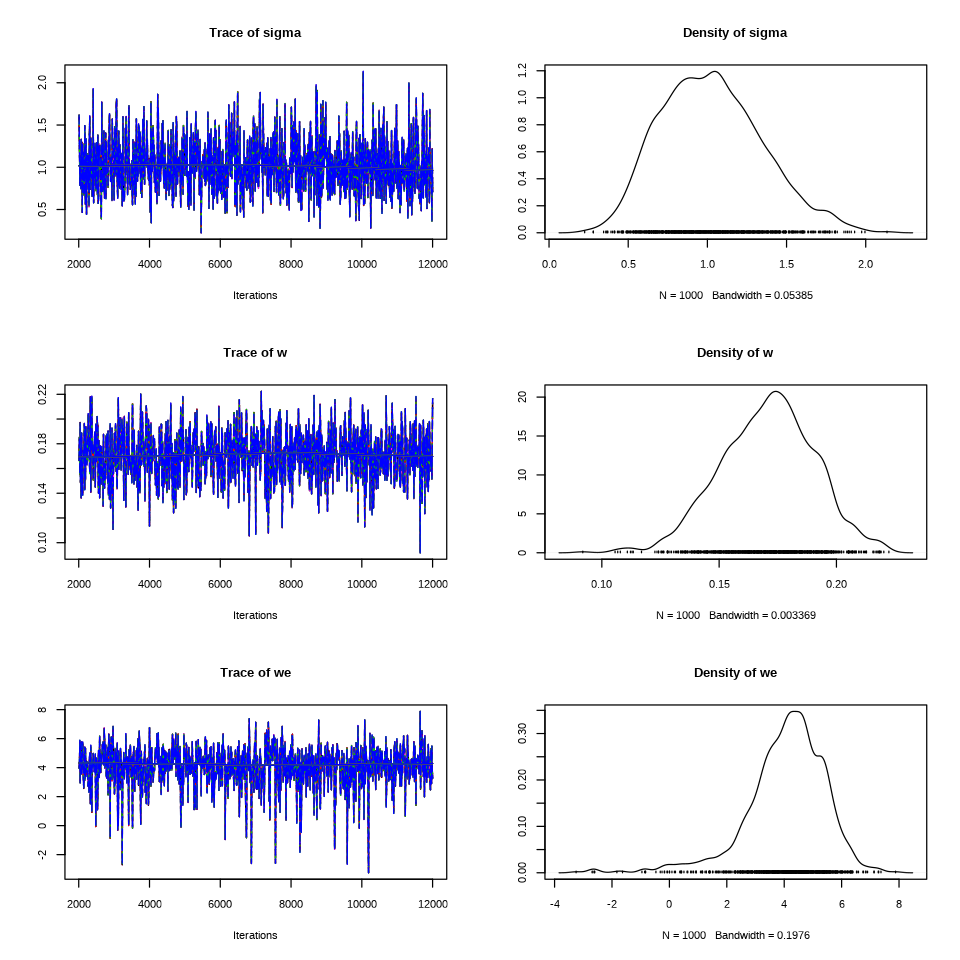

In [58]:
chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)
summary(chain)$statistics
set_plot_dimensions(8,8)
plot(chain)

In [59]:
w  <- summary(chain)$statistics[2,1]; sw<-  summary(chain)$statistics[2,2]
we  <- summary(chain)$statistics[3,1]; swe <- summary(chain)$statistics[3,2]
w
we

[1] 0.1706003

[1] 4.051752

In [65]:
?legend

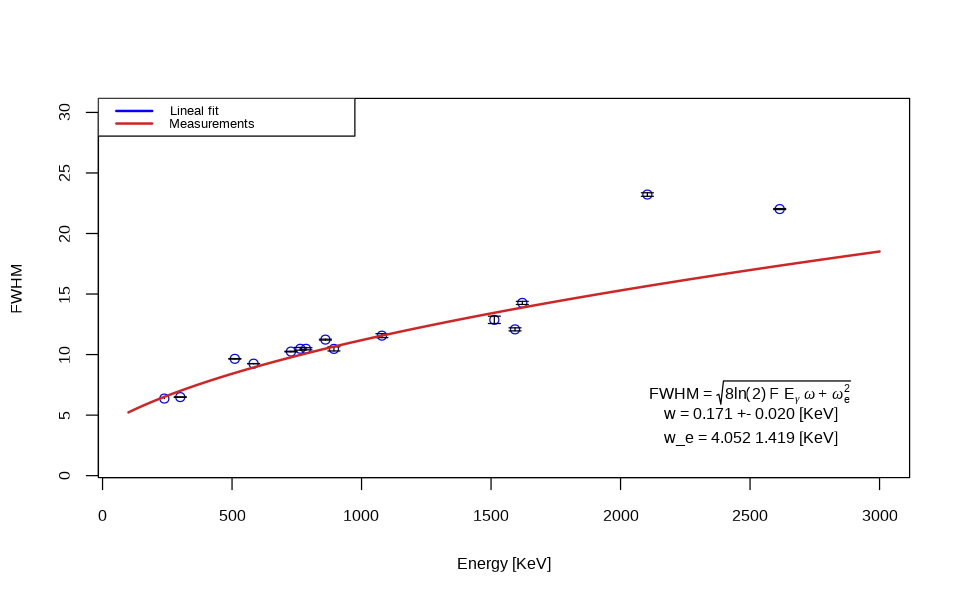

In [68]:
fano <-0.115
    
x <- seq(100,3000,1)
f <- sqrt(4*2*log(2) * fano * x * w + we**2)
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 5)
plot(df_T$T_energies,df_T$FWHM_mean,col="blue",
    xlim=c(100,3000), ylim=c(1,30), 
    xlab="Energy [KeV]",ylab="FWHM",
    main="")

arrows(df_T$T_energies, df_T$FWHM_mean-df_T$FWHM_std,
       df_T$T_energies, df_T$FWHM_mean+df_T$FWHM_std,
       length=0.05, angle=90, code=3)

lines(x,f, lwd=2, col='firebrick3')


legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("blue","firebrick3"), lty=1,lwd=2, cex=0.8)

#text(df_T$T_energies,df_T$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2500, 7,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2500, 5, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2500, 3, paste("w_e =", sprintf("%.3f",we),sprintf("%.3f",swe),"[KeV]"))